In [1]:
%load_ext autoreload
%matplotlib notebook
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_probability.python.distributions as tfd

In [4]:
from pydpc import Cluster as DPCClustering

In [5]:
from networks import *

Three archetypes are defined on a two dimensional space.

In [6]:
archetypes_init = np.array([[1,0],
                  [2,2],
                  [0,1]])

In [7]:
def generate_data (archs, n_points, noise=0.1):
    
    k = len(archs)
    X,Y = archs.T 
    rand = np.random.uniform (0,1,[k,n_points])
    rand = (rand/np.sum(rand,axis=0)).T
    data = np.matmul(rand,archs)
    data = data + np.random.normal(0,noise,size=data.shape)
    Y0=np.linalg.norm(data-archs[0],axis=1)
    Y1=np.linalg.norm(data-archs[1],axis=1)
    Y2=np.linalg.norm(data-archs[2],axis=1)
    Y0=Y0/np.max(Y0)
    Y1=Y1/np.max(Y1)
    Y2=Y2/np.max(Y2)
    Y=np.concatenate((np.expand_dims(Y0,axis=1),np.expand_dims(Y1,axis=1),np.expand_dims(Y2,axis=1)),axis=1)
    
    return data, Y

Data is generated as a linear combination of the archetypes. Constrains on the weights are added so as to ensure that the generated data set is a convex mixture of the archetypes. Noise is then added, hence the resulting points can be defined outside the convex hull. Each data point has associated a side information vector  $\vec{Y}=(Y_0,Y_1,Y_2)$, where each component is the distance from one of the archetypes. Side information can be generalised to more complex functions. In the figure below we can see the three archetypes in blue, and the data set in different shades of red. Colors are obtained from the side information, that is used as entry for a RGB  color model.

# Synthetic data
---

<IPython.core.display.Javascript object>


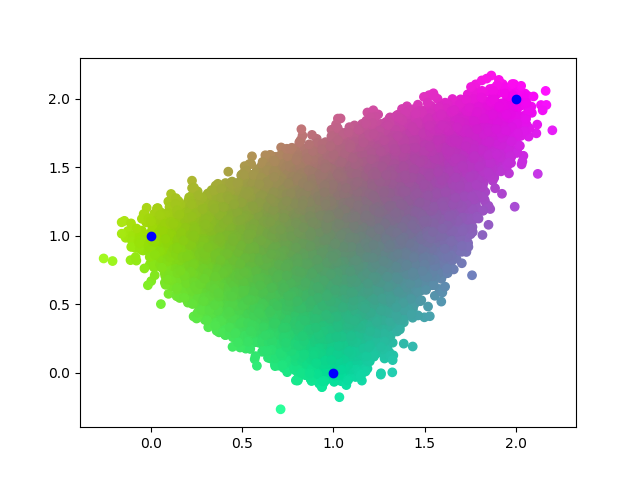

In [8]:
x_train, y_train = generate_data (archetypes_init,100000,noise=0.1)
x_test, y_test = generate_data (archetypes_init,1000,noise=0.1)

data0,data1 = x_train.T
plt.scatter(data0, data1, color=y_train)
data0,data1 = archetypes_init.T
plt.scatter(data0, data1, color='blue')


We use variational autoencoders to map the data set into a latent space. The neural network is constructed to force data in latent space to be defined within an arbitrary convex hull. We use a triangular convex hull as shown below. 

We construct a variational autoencoder that generates a mean $\mu$, and a standard deviation $\sigma$ for each data point. The point is then mapped into the latent space with a stochastic extraction from a Gaussian $\mathcal{N}(\mu,\,\sigma^{2})$, where $\mu$'s are by construction within a hull $z_{fixed}$. 

In [8]:
original_dim = x_train.shape [1]
sideinfo_dim = y_train.shape [1]

x_train = np.array(np.reshape(x_train, [-1, original_dim]), dtype='float32')
x_test = np.array(np.reshape(x_test, [-1, original_dim]), dtype='float32')
y_train = np.array(np.reshape(y_train, [-1, sideinfo_dim]), dtype='float32')
y_test = np.array(np.reshape(y_test, [-1, sideinfo_dim]), dtype='float32')

# network parameters
intermediate_dim = 4
batch_size = 1024 
latent_dim = 2
simplex_vrtxs = latent_dim + 1

# cost function paramters
reconstruction_factor = 1
class_factor = 1
kl_factor = 0
archetype_factor = 1

vae = VAE(original_dim, intermediate_dim, latent_dim, sideinfo_dim)
vae.add_loss(reconstruction_factor, class_factor, kl_factor, archetype_factor)
vae.network.compile(optimizer='adam')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 4)            12          encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4)            20          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 3)            15          dense_1[0][0]                    
____________________________________________________________________________________________

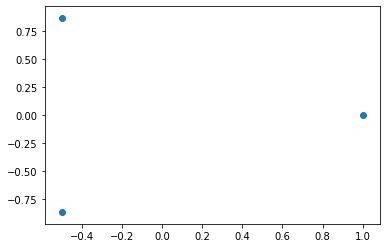

In [37]:
zfixed = vae.get_zfixed()
data0,data1 = zfixed.T
plt.scatter(data0, data1)

In [38]:
epochs = 500

vae.network.fit([x_train,y_train],  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test,y_test],None))

Train on 100000 samples, validate on 1000 samples
Epoch 1/500
100000/100000 [==============================] - 1s 10us/sample - loss: 2.3169 - val_loss: 1.9179
Epoch 2/500
100000/100000 [==============================] - 0s 2us/sample - loss: 1.7674 - val_loss: 1.7247
Epoch 3/500
100000/100000 [==============================] - 0s 2us/sample - loss: 1.6309 - val_loss: 1.5505
Epoch 4/500
100000/100000 [==============================] - 0s 2us/sample - loss: 1.3763 - val_loss: 1.1716
Epoch 5/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.8881 - val_loss: 0.6769
Epoch 6/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.4558 - val_loss: 0.3660
Epoch 7/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2798 - val_loss: 0.2661
Epoch 8/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.2125 - val_loss: 0.2309
Epoch 9/500
100000/100000 [==============================] - 0s 3us/sample - 

100000/100000 [==============================] - 0s 3us/sample - loss: 0.0504 - val_loss: 0.0617
Epoch 76/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0496 - val_loss: 0.0644
Epoch 77/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0492 - val_loss: 0.0655
Epoch 78/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0480 - val_loss: 0.0659
Epoch 79/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0477 - val_loss: 0.0569
Epoch 80/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0471 - val_loss: 0.0561
Epoch 81/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0483 - val_loss: 0.0541
Epoch 82/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0461 - val_loss: 0.0583
Epoch 83/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0457 - val_loss: 0.0550
Epoch 84/500
100000/100

Epoch 223/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0052 - val_loss: 0.0098
Epoch 224/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0052 - val_loss: 0.0099
Epoch 225/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0051 - val_loss: 0.0101
Epoch 226/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0053 - val_loss: 0.0099
Epoch 227/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0051 - val_loss: 0.0100
Epoch 228/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0051 - val_loss: 0.0098
Epoch 229/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0051 - val_loss: 0.0099
Epoch 230/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0051 - val_loss: 0.0099
Epoch 231/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0051 - val_loss: 0.0099
E

Epoch 297/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0043 - val_loss: 0.0093
Epoch 298/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0042 - val_loss: 0.0090
Epoch 299/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0043 - val_loss: 0.0087
Epoch 300/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0043 - val_loss: 0.0091
Epoch 301/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0043 - val_loss: 0.0089
Epoch 302/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0042 - val_loss: 0.0088
Epoch 303/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0042 - val_loss: 0.0088
Epoch 304/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0042 - val_loss: 0.0090
Epoch 305/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0042 - val_loss: 0.0087
E

Epoch 371/500
100000/100000 [==============================] - 0s 3us/sample - loss: 0.0040 - val_loss: 0.0088
Epoch 372/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0040 - val_loss: 0.0088
Epoch 373/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0039 - val_loss: 0.0088
Epoch 374/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0040 - val_loss: 0.0086
Epoch 375/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0039 - val_loss: 0.0093
Epoch 376/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0040 - val_loss: 0.0086
Epoch 377/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0041 - val_loss: 0.0086
Epoch 378/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0040 - val_loss: 0.0085
Epoch 379/500
100000/100000 [==============================] - 0s 2us/sample - loss: 0.0040 - val_loss: 0.0090
E

KeyboardInterrupt: 

In [39]:
archetypes_pred = vae.decoder.predict([vae.get_zfixed(),np.zeros([3,3])])[0]

In [40]:
t,mu,sigma, B_t, y = vae.encoder.predict([x_train,np.zeros(np.shape(y_train))])

$\mu$'s are generated within an arbitrary triangular hull. Below we see the $\mu$'s in latent space in blue, and the vertexes of the arbitrarily chosen hull in orange.

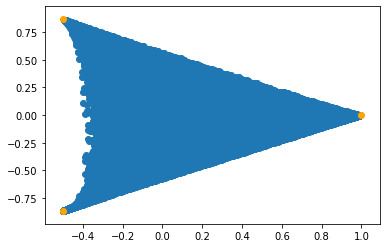

In [41]:
dataX,dataY = mu.T
plt.scatter(dataX,dataY)
zfixed = vae.get_zfixed ()
data0,data1 = zfixed.T
plt.scatter(data0, data1,color='orange')

Using the data points initially generated we are able to reconstruct the initial points that have been taken as archetypes. Below, we see in blue the archetypes initailly defined, and in orange the predicted ones.

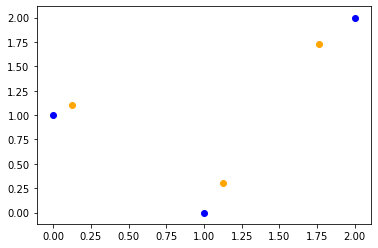

In [42]:
dataX,dataY = archetypes_init.T
plt.scatter(dataX,dataY,color='blue')

dataX,dataY = np.array(archetypes_pred).T
plt.scatter(dataX,dataY,color='orange')


We can feed the trained network with some test data and see that is able to reconstruct the data and side information after mapping into latent space.

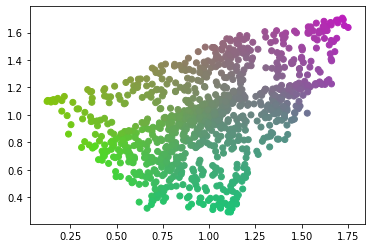

In [43]:
t, y_pred = vae.network.predict([x_test,np.zeros(np.shape(y_test))])
dataX,dataY = t.T

if (np.min(y_pred)<0):
    y_pred += np.abs(np.min(y_pred))
if (np.min(y_pred)>1):
    y_pred /= np.abs(np.max(y_pred))

plt.scatter(dataX,dataY,color=y_pred)

Below we can see the original test data. If we compare the original data with the results of the variational encoder above, we can see that the encoder has the effect of a regularizer, i.e. the resulting effect is that noise is removed and data lie within the convex hull.

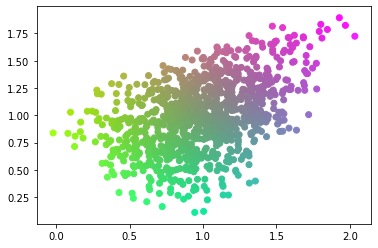

In [44]:
dataX,dataY = x_test.T
plt.scatter(dataX,dataY,color=y_test)

# Real data
---

In [110]:
df = pd.read_table("./data/perovskites/cubic_perosvkistes_data.asc", sep=' ')
df = df.dropna(axis=1)
df['type'] = df.apply(lambda x : 1 if  x['band_gap'] < 0.2  else 0 , axis=1)
hover_features = ['type','material']

In [9]:
features = df.drop(['band_gap','material','type'],axis=1).columns.tolist()
clu=DPCClustering(np.ascontiguousarray(df[features].to_numpy()), autoplot=False)
clu.assign(10,15)
cluster_labels = clu.membership
df['labels']=cluster_labels


In [10]:
df

,material,lattice_constant,bul_modulus,band_gap,rS_A,rP_A,rS_B,rP_B,Z_A,Z_B,...,LUMO_A,EA_A,IP_A,HOMO_B,LUMO_B,EA_B,IP_B,c_A,type,labels
0,LiAlO3,3.664037,0.880584,0.012362,1.6868,2.0999,1.1041,1.4313,3,13,...,-2.874022,-0.841608,5.167975,-2.547095,-2.547095,-0.308078,5.449666,1.0,1,0
1,LiTiO3,3.819180,1.026964,0.042909,1.6868,2.0999,1.5412,2.0894,3,22,...,-2.874022,-0.841608,5.167975,-3.667603,-3.667603,-0.021725,7.552224,1.0,1,0
2,LiVO3,3.681826,1.262593,0.917638,1.6868,2.0999,1.4597,2.0470,3,23,...,-2.874022,-0.841608,5.167975,-4.798407,-4.798407,-0.664677,7.407416,1.0,0,0
3,LiCrO3,3.621000,1.305761,0.008070,1.6868,2.0999,1.4247,2.0121,3,24,...,-2.874022,-0.841608,5.167975,-4.733548,-4.733549,-1.259830,6.979022,1.0,1,0
4,LiMnO3,3.587877,1.294018,0.006193,1.6868,2.0999,0.4135,2.1824,3,25,...,-2.874022,-0.841608,5.167975,-4.333466,-0.671345,-1.423902,6.884430,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,SmTaO3,3.977564,1.313190,0.003494,1.9576,2.7175,1.4730,2.0840,62,73,...,-2.136208,0.614261,6.052163,-3.410814,-3.410814,-0.207863,7.364064,3.0,1,6
500,SmWO3,3.922344,1.403928,0.004626,1.9576,2.7175,1.4161,2.1126,62,74,...,-2.136208,0.614261,6.052163,-4.437043,-4.437043,-0.922676,8.672460,3.0,1,6
501,SmPtO3,3.972722,1.125694,0.006673,1.9576,2.7175,1.3361,1.8009,62,78,...,-2.136208,0.614261,6.052163,-5.316149,-4.051110,-1.310324,10.114268,3.0,1,6
502,SmPbO3,4.247913,0.783865,0.004422,1.9576,2.7175,1.0452,1.4235,62,82,...,-2.136208,0.614261,6.052163,-3.503690,-3.503690,-0.958997,6.476888,3.0,1,6


In [88]:
x_train = df.drop('material', axis=1).to_numpy()
original_dim = x_train.shape [1]
sideinfo_dim = 1

x_train = np.array(np.reshape(x_train, [-1, original_dim]), dtype='float32')
# y_train = np.zeros([len(x_train), sideinfo_dim], dtype='float32')
y_train = df['type'].to_numpy()

# network parameters
intermediate_dim = 16
latent_dim = 2
simplex_vrtxs = latent_dim + 1

# cost function paramters
reconstruction_factor = 1
class_factor = 0
kl_factor = 0.5
archetype_factor = 10

# reconstruction_factor = 1
# class_factor = 0
# kl_factor = 1
# archetype_factor = 1

vae = VAE(original_dim, intermediate_dim, latent_dim, sideinfo_dim)
vae.add_loss(reconstruction_factor, class_factor, kl_factor, archetype_factor)
vae.network.compile(optimizer='adam')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_x (InputLayer)    [(None, 22)]         0                                            
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 16)           368         encoder_input_x[0][0]            
__________________________________________________________________________________________________
dense_133 (Dense)               (None, 16)           272         dense_132[0][0]                  
__________________________________________________________________________________________________
dense_134 (Dense)               (None, 3)            51          dense_133[0][0]                  
____________________________________________________________________________________________

In [89]:
epochs = 200
batch_size = 4 
while (batch_size<500):
    vae.network.fit([x_train,y_train],  
            epochs=epochs,
            batch_size=batch_size)
    batch_size = batch_size * 2
    epochs = epochs * 2

Train on 504 samples
Epoch 1/200
504/504 [==============================] - 1s 2ms/sample - loss: 10653069.0693
Epoch 2/200
504/504 [==============================] - 1s 1ms/sample - loss: 9763.5327
Epoch 3/200
504/504 [==============================] - 1s 1ms/sample - loss: 3597.3700
Epoch 4/200
504/504 [==============================] - 1s 1ms/sample - loss: 1993.6594
Epoch 5/200
504/504 [==============================] - 1s 1ms/sample - loss: 1271.0682
Epoch 6/200
504/504 [==============================] - 1s 1ms/sample - loss: 877.8388
Epoch 7/200
504/504 [==============================] - 1s 1ms/sample - loss: 652.6727
Epoch 8/200
504/504 [==============================] - 1s 1ms/sample - loss: 507.5690
Epoch 9/200
504/504 [==============================] - 1s 1ms/sample - loss: 406.1257
Epoch 10/200
504/504 [==============================] - 1s 1ms/sample - loss: 335.5326
Epoch 11/200
504/504 [==============================] - 1s 1ms/sample - loss: 281.8605
Epoch 12/200
504/504 [

504/504 [==============================] - 1s 1ms/sample - loss: 32.0279
Epoch 96/200
504/504 [==============================] - 1s 1ms/sample - loss: 31.5792
Epoch 97/200
504/504 [==============================] - 1s 1ms/sample - loss: 31.6297
Epoch 98/200
504/504 [==============================] - 1s 1ms/sample - loss: 30.5536
Epoch 99/200
504/504 [==============================] - 1s 1ms/sample - loss: 33.1779
Epoch 100/200
504/504 [==============================] - 1s 1ms/sample - loss: 30.4913
Epoch 101/200
504/504 [==============================] - 1s 995us/sample - loss: 30.8247
Epoch 102/200
504/504 [==============================] - 1s 1ms/sample - loss: 30.6598
Epoch 103/200
504/504 [==============================] - 1s 998us/sample - loss: 31.5741
Epoch 104/200
504/504 [==============================] - 1s 1ms/sample - loss: 31.0801
Epoch 105/200
504/504 [==============================] - 1s 1ms/sample - loss: 30.1969
Epoch 106/200
504/504 [==============================] - 

504/504 [==============================] - 1s 1ms/sample - loss: 23.1974
Epoch 190/200
504/504 [==============================] - 0s 992us/sample - loss: 24.0178
Epoch 191/200
504/504 [==============================] - 1s 1ms/sample - loss: 24.8866
Epoch 192/200
504/504 [==============================] - 1s 1ms/sample - loss: 25.0229
Epoch 193/200
504/504 [==============================] - 1s 1ms/sample - loss: 22.9310
Epoch 194/200
504/504 [==============================] - 1s 1ms/sample - loss: 25.3970
Epoch 195/200
504/504 [==============================] - 1s 1ms/sample - loss: 24.0237
Epoch 196/200
504/504 [==============================] - 0s 966us/sample - loss: 24.3726
Epoch 197/200
504/504 [==============================] - 1s 1ms/sample - loss: 25.0720
Epoch 198/200
504/504 [==============================] - 1s 1ms/sample - loss: 22.8366
Epoch 199/200
504/504 [==============================] - 1s 995us/sample - loss: 23.6675
Epoch 200/200
504/504 [============================

504/504 [==============================] - 0s 548us/sample - loss: 14.9463
Epoch 83/400
504/504 [==============================] - 0s 526us/sample - loss: 14.4509
Epoch 84/400
504/504 [==============================] - 0s 516us/sample - loss: 17.4901
Epoch 85/400
504/504 [==============================] - 0s 534us/sample - loss: 15.6315
Epoch 86/400
504/504 [==============================] - 0s 543us/sample - loss: 14.0313
Epoch 87/400
504/504 [==============================] - 0s 522us/sample - loss: 13.8836
Epoch 88/400
504/504 [==============================] - 0s 537us/sample - loss: 15.0783
Epoch 89/400
504/504 [==============================] - 0s 503us/sample - loss: 15.3190
Epoch 90/400
504/504 [==============================] - 0s 527us/sample - loss: 16.5430
Epoch 91/400
504/504 [==============================] - 0s 512us/sample - loss: 15.8934
Epoch 92/400
504/504 [==============================] - 0s 563us/sample - loss: 16.2522
Epoch 93/400
504/504 [=======================

504/504 [==============================] - 0s 548us/sample - loss: 12.1430
Epoch 175/400
504/504 [==============================] - 0s 550us/sample - loss: 12.1107
Epoch 176/400
504/504 [==============================] - 0s 560us/sample - loss: 12.2479
Epoch 177/400
504/504 [==============================] - 0s 522us/sample - loss: 12.4531
Epoch 178/400
504/504 [==============================] - 0s 508us/sample - loss: 13.1626
Epoch 179/400
504/504 [==============================] - 0s 544us/sample - loss: 12.7955
Epoch 180/400
504/504 [==============================] - 0s 516us/sample - loss: 13.3269
Epoch 181/400
504/504 [==============================] - 0s 566us/sample - loss: 11.6139
Epoch 182/400
504/504 [==============================] - 0s 558us/sample - loss: 13.9370
Epoch 183/400
504/504 [==============================] - 0s 528us/sample - loss: 14.2636
Epoch 184/400
504/504 [==============================] - 0s 509us/sample - loss: 12.6967
Epoch 185/400
504/504 [============

504/504 [==============================] - 0s 525us/sample - loss: 8.9151
Epoch 267/400
504/504 [==============================] - 0s 518us/sample - loss: 9.2666
Epoch 268/400
504/504 [==============================] - 0s 573us/sample - loss: 9.7366
Epoch 269/400
504/504 [==============================] - 0s 564us/sample - loss: 9.8126
Epoch 270/400
504/504 [==============================] - 0s 560us/sample - loss: 8.9753
Epoch 271/400
504/504 [==============================] - 0s 521us/sample - loss: 8.4314
Epoch 272/400
504/504 [==============================] - 0s 572us/sample - loss: 10.9468
Epoch 273/400
504/504 [==============================] - 0s 522us/sample - loss: 9.1357
Epoch 274/400
504/504 [==============================] - 0s 523us/sample - loss: 9.4596
Epoch 275/400
504/504 [==============================] - 0s 504us/sample - loss: 9.7172
Epoch 276/400
504/504 [==============================] - 0s 509us/sample - loss: 9.6001
Epoch 277/400
504/504 [======================

504/504 [==============================] - 0s 550us/sample - loss: 8.7677
Epoch 360/400
504/504 [==============================] - 0s 550us/sample - loss: 7.2941
Epoch 361/400
504/504 [==============================] - 0s 526us/sample - loss: 8.6518
Epoch 362/400
504/504 [==============================] - 0s 585us/sample - loss: 9.6085
Epoch 363/400
504/504 [==============================] - 0s 522us/sample - loss: 7.6701
Epoch 364/400
504/504 [==============================] - 0s 526us/sample - loss: 6.5351
Epoch 365/400
504/504 [==============================] - 0s 535us/sample - loss: 6.9138
Epoch 366/400
504/504 [==============================] - 0s 606us/sample - loss: 7.8994
Epoch 367/400
504/504 [==============================] - 0s 511us/sample - loss: 7.0345
Epoch 368/400
504/504 [==============================] - 0s 505us/sample - loss: 6.6325
Epoch 369/400
504/504 [==============================] - 0s 523us/sample - loss: 7.0405
Epoch 370/400
504/504 [=======================

504/504 [==============================] - 0s 336us/sample - loss: 4.6555
Epoch 53/800
504/504 [==============================] - 0s 313us/sample - loss: 5.4030
Epoch 54/800
504/504 [==============================] - 0s 361us/sample - loss: 5.5305
Epoch 55/800
504/504 [==============================] - 0s 328us/sample - loss: 5.1537
Epoch 56/800
504/504 [==============================] - 0s 318us/sample - loss: 4.9295
Epoch 57/800
504/504 [==============================] - 0s 324us/sample - loss: 5.2877
Epoch 58/800
504/504 [==============================] - 0s 282us/sample - loss: 5.7026
Epoch 59/800
504/504 [==============================] - 0s 352us/sample - loss: 4.7396
Epoch 60/800
504/504 [==============================] - 0s 315us/sample - loss: 4.9481
Epoch 61/800
504/504 [==============================] - 0s 365us/sample - loss: 5.2917
Epoch 62/800
504/504 [==============================] - 0s 306us/sample - loss: 5.4267
Epoch 63/800
504/504 [==============================] - 

504/504 [==============================] - 0s 327us/sample - loss: 4.6736
Epoch 146/800
504/504 [==============================] - 0s 334us/sample - loss: 4.5415
Epoch 147/800
504/504 [==============================] - 0s 320us/sample - loss: 4.5511
Epoch 148/800
504/504 [==============================] - 0s 351us/sample - loss: 4.4781
Epoch 149/800
504/504 [==============================] - 0s 304us/sample - loss: 4.1609
Epoch 150/800
504/504 [==============================] - 0s 365us/sample - loss: 4.1371
Epoch 151/800
504/504 [==============================] - 0s 321us/sample - loss: 4.2426
Epoch 152/800
504/504 [==============================] - 0s 348us/sample - loss: 4.2743
Epoch 153/800
504/504 [==============================] - 0s 336us/sample - loss: 4.6740
Epoch 154/800
504/504 [==============================] - 0s 334us/sample - loss: 4.4360
Epoch 155/800
504/504 [==============================] - 0s 340us/sample - loss: 3.9801
Epoch 156/800
504/504 [=======================

504/504 [==============================] - 0s 304us/sample - loss: 4.4524
Epoch 239/800
504/504 [==============================] - 0s 342us/sample - loss: 3.2450
Epoch 240/800
504/504 [==============================] - 0s 352us/sample - loss: 3.8738
Epoch 241/800
504/504 [==============================] - 0s 318us/sample - loss: 4.0370
Epoch 242/800
504/504 [==============================] - 0s 314us/sample - loss: 3.4083
Epoch 243/800
504/504 [==============================] - 0s 323us/sample - loss: 3.9194
Epoch 244/800
504/504 [==============================] - 0s 324us/sample - loss: 3.4941
Epoch 245/800
504/504 [==============================] - 0s 312us/sample - loss: 3.6250
Epoch 246/800
504/504 [==============================] - 0s 330us/sample - loss: 3.1803
Epoch 247/800
504/504 [==============================] - 0s 343us/sample - loss: 3.4943
Epoch 248/800
504/504 [==============================] - 0s 332us/sample - loss: 3.3933
Epoch 249/800
504/504 [=======================

504/504 [==============================] - 0s 331us/sample - loss: 2.9688
Epoch 332/800
504/504 [==============================] - 0s 328us/sample - loss: 3.2544
Epoch 333/800
504/504 [==============================] - 0s 325us/sample - loss: 2.9615
Epoch 334/800
504/504 [==============================] - 0s 332us/sample - loss: 2.8439
Epoch 335/800
504/504 [==============================] - 0s 325us/sample - loss: 3.2131
Epoch 336/800
504/504 [==============================] - 0s 323us/sample - loss: 3.3879
Epoch 337/800
504/504 [==============================] - 0s 347us/sample - loss: 3.6899
Epoch 338/800
504/504 [==============================] - 0s 293us/sample - loss: 3.5330
Epoch 339/800
504/504 [==============================] - 0s 370us/sample - loss: 3.2819
Epoch 340/800
504/504 [==============================] - 0s 313us/sample - loss: 3.5468
Epoch 341/800
504/504 [==============================] - 0s 334us/sample - loss: 3.3228
Epoch 342/800
504/504 [=======================

504/504 [==============================] - 0s 328us/sample - loss: 3.1439
Epoch 425/800
504/504 [==============================] - 0s 326us/sample - loss: 3.0538
Epoch 426/800
504/504 [==============================] - 0s 310us/sample - loss: 2.5365
Epoch 427/800
504/504 [==============================] - 0s 336us/sample - loss: 2.7997
Epoch 428/800
504/504 [==============================] - 0s 320us/sample - loss: 2.9409
Epoch 429/800
504/504 [==============================] - 0s 359us/sample - loss: 3.0149
Epoch 430/800
504/504 [==============================] - 0s 311us/sample - loss: 2.9697
Epoch 431/800
504/504 [==============================] - 0s 327us/sample - loss: 2.8879
Epoch 432/800
504/504 [==============================] - 0s 312us/sample - loss: 2.7991
Epoch 433/800
504/504 [==============================] - 0s 324us/sample - loss: 2.7961
Epoch 434/800
504/504 [==============================] - 0s 317us/sample - loss: 2.6982
Epoch 435/800
504/504 [=======================

504/504 [==============================] - 0s 314us/sample - loss: 2.3324
Epoch 518/800
504/504 [==============================] - 0s 337us/sample - loss: 2.3231
Epoch 519/800
504/504 [==============================] - 0s 325us/sample - loss: 2.4463
Epoch 520/800
504/504 [==============================] - 0s 353us/sample - loss: 2.3208
Epoch 521/800
504/504 [==============================] - 0s 342us/sample - loss: 2.7328
Epoch 522/800
504/504 [==============================] - 0s 307us/sample - loss: 2.6022
Epoch 523/800
504/504 [==============================] - 0s 318us/sample - loss: 2.5948
Epoch 524/800
504/504 [==============================] - 0s 340us/sample - loss: 2.6922
Epoch 525/800
504/504 [==============================] - 0s 299us/sample - loss: 2.8040
Epoch 526/800
504/504 [==============================] - 0s 329us/sample - loss: 2.6872
Epoch 527/800
504/504 [==============================] - 0s 324us/sample - loss: 2.6232
Epoch 528/800
504/504 [=======================

504/504 [==============================] - 0s 299us/sample - loss: 2.8502
Epoch 611/800
504/504 [==============================] - 0s 339us/sample - loss: 2.5470
Epoch 612/800
504/504 [==============================] - 0s 287us/sample - loss: 2.3585
Epoch 613/800
504/504 [==============================] - 0s 320us/sample - loss: 2.3946
Epoch 614/800
504/504 [==============================] - 0s 309us/sample - loss: 2.4881
Epoch 615/800
504/504 [==============================] - 0s 309us/sample - loss: 2.8918
Epoch 616/800
504/504 [==============================] - 0s 329us/sample - loss: 2.2412
Epoch 617/800
504/504 [==============================] - 0s 335us/sample - loss: 2.6727
Epoch 618/800
504/504 [==============================] - 0s 287us/sample - loss: 2.4855
Epoch 619/800
504/504 [==============================] - 0s 317us/sample - loss: 2.6816
Epoch 620/800
504/504 [==============================] - 0s 295us/sample - loss: 2.8152
Epoch 621/800
504/504 [=======================

504/504 [==============================] - 0s 328us/sample - loss: 2.1972
Epoch 704/800
504/504 [==============================] - 0s 324us/sample - loss: 2.3166
Epoch 705/800
504/504 [==============================] - 0s 297us/sample - loss: 2.2244
Epoch 706/800
504/504 [==============================] - 0s 286us/sample - loss: 2.4009
Epoch 707/800
504/504 [==============================] - 0s 310us/sample - loss: 2.4400
Epoch 708/800
504/504 [==============================] - 0s 308us/sample - loss: 2.3556
Epoch 709/800
504/504 [==============================] - 0s 321us/sample - loss: 2.1848
Epoch 710/800
504/504 [==============================] - 0s 278us/sample - loss: 1.8575
Epoch 711/800
504/504 [==============================] - 0s 304us/sample - loss: 2.2358
Epoch 712/800
504/504 [==============================] - 0s 305us/sample - loss: 2.1286
Epoch 713/800
504/504 [==============================] - 0s 292us/sample - loss: 2.3456
Epoch 714/800
504/504 [=======================

504/504 [==============================] - 0s 308us/sample - loss: 1.9284
Epoch 797/800
504/504 [==============================] - 0s 296us/sample - loss: 2.2013
Epoch 798/800
504/504 [==============================] - 0s 293us/sample - loss: 2.3749
Epoch 799/800
504/504 [==============================] - 0s 284us/sample - loss: 1.9953
Epoch 800/800
504/504 [==============================] - 0s 311us/sample - loss: 2.2945
Train on 504 samples
Epoch 1/1600
504/504 [==============================] - 0s 148us/sample - loss: 1.6914
Epoch 2/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.4610
Epoch 3/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.5638
Epoch 4/1600
504/504 [==============================] - 0s 165us/sample - loss: 1.4815
Epoch 5/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.4102
Epoch 6/1600
504/504 [==============================] - 0s 169us/sample - loss: 1.4801
Epoch 7/1600
504/504 [=========

504/504 [==============================] - 0s 153us/sample - loss: 1.5663
Epoch 90/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.5187
Epoch 91/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.5828
Epoch 92/1600
504/504 [==============================] - 0s 148us/sample - loss: 1.5228
Epoch 93/1600
504/504 [==============================] - 0s 163us/sample - loss: 1.4068
Epoch 94/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.2428
Epoch 95/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.3243
Epoch 96/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.3527
Epoch 97/1600
504/504 [==============================] - 0s 163us/sample - loss: 1.6034
Epoch 98/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.4328
Epoch 99/1600
504/504 [==============================] - 0s 162us/sample - loss: 1.4544
Epoch 100/1600
504/504 [======================

504/504 [==============================] - 0s 167us/sample - loss: 1.8778
Epoch 182/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.7803
Epoch 183/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.8723
Epoch 184/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.9248
Epoch 185/1600
504/504 [==============================] - 0s 169us/sample - loss: 1.7181
Epoch 186/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.9448
Epoch 187/1600
504/504 [==============================] - 0s 141us/sample - loss: 1.8039
Epoch 188/1600
504/504 [==============================] - 0s 147us/sample - loss: 1.9502
Epoch 189/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.6465
Epoch 190/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.5634
Epoch 191/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.8616
Epoch 192/1600
504/504 [============

504/504 [==============================] - 0s 163us/sample - loss: 1.7323
Epoch 274/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.5478
Epoch 275/1600
504/504 [==============================] - 0s 166us/sample - loss: 1.5845
Epoch 276/1600
504/504 [==============================] - 0s 169us/sample - loss: 1.7766
Epoch 277/1600
504/504 [==============================] - 0s 174us/sample - loss: 1.9623
Epoch 278/1600
504/504 [==============================] - 0s 166us/sample - loss: 1.5524
Epoch 279/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.5636
Epoch 280/1600
504/504 [==============================] - 0s 173us/sample - loss: 1.8536
Epoch 281/1600
504/504 [==============================] - 0s 163us/sample - loss: 1.7707
Epoch 282/1600
504/504 [==============================] - 0s 173us/sample - loss: 1.7519
Epoch 283/1600
504/504 [==============================] - 0s 177us/sample - loss: 1.8671
Epoch 284/1600
504/504 [============

504/504 [==============================] - 0s 143us/sample - loss: 1.8110
Epoch 366/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.7832
Epoch 367/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.6498
Epoch 368/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.4524
Epoch 369/1600
504/504 [==============================] - 0s 175us/sample - loss: 1.8038
Epoch 370/1600
504/504 [==============================] - 0s 148us/sample - loss: 1.8507
Epoch 371/1600
504/504 [==============================] - 0s 179us/sample - loss: 1.5130
Epoch 372/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.6459
Epoch 373/1600
504/504 [==============================] - 0s 148us/sample - loss: 1.5983
Epoch 374/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.5932
Epoch 375/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.8004
Epoch 376/1600
504/504 [============

504/504 [==============================] - 0s 171us/sample - loss: 1.4703
Epoch 458/1600
504/504 [==============================] - 0s 162us/sample - loss: 1.3902
Epoch 459/1600
504/504 [==============================] - 0s 200us/sample - loss: 1.5923
Epoch 460/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.7084
Epoch 461/1600
504/504 [==============================] - 0s 163us/sample - loss: 1.5880
Epoch 462/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.5649
Epoch 463/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.3599
Epoch 464/1600
504/504 [==============================] - 0s 153us/sample - loss: 1.5768
Epoch 465/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.4891
Epoch 466/1600
504/504 [==============================] - 0s 160us/sample - loss: 1.7059
Epoch 467/1600
504/504 [==============================] - 0s 146us/sample - loss: 1.6064
Epoch 468/1600
504/504 [============

504/504 [==============================] - 0s 153us/sample - loss: 1.7246
Epoch 550/1600
504/504 [==============================] - 0s 166us/sample - loss: 1.5433
Epoch 551/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.5527
Epoch 552/1600
504/504 [==============================] - 0s 156us/sample - loss: 1.7634
Epoch 553/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.6605
Epoch 554/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.3569
Epoch 555/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.4310
Epoch 556/1600
504/504 [==============================] - 0s 164us/sample - loss: 1.5223
Epoch 557/1600
504/504 [==============================] - 0s 144us/sample - loss: 1.6152
Epoch 558/1600
504/504 [==============================] - 0s 153us/sample - loss: 1.4574
Epoch 559/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.6316
Epoch 560/1600
504/504 [============

504/504 [==============================] - 0s 177us/sample - loss: 1.6382
Epoch 642/1600
504/504 [==============================] - 0s 157us/sample - loss: 1.4033
Epoch 643/1600
504/504 [==============================] - 0s 146us/sample - loss: 1.5025
Epoch 644/1600
504/504 [==============================] - 0s 165us/sample - loss: 1.3231
Epoch 645/1600
504/504 [==============================] - 0s 146us/sample - loss: 1.4502
Epoch 646/1600
504/504 [==============================] - 0s 157us/sample - loss: 1.3438
Epoch 647/1600
504/504 [==============================] - 0s 167us/sample - loss: 1.4122
Epoch 648/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.5730
Epoch 649/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.4305
Epoch 650/1600
504/504 [==============================] - 0s 139us/sample - loss: 1.5485
Epoch 651/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.4523
Epoch 652/1600
504/504 [============

504/504 [==============================] - 0s 167us/sample - loss: 1.4487
Epoch 734/1600
504/504 [==============================] - 0s 164us/sample - loss: 1.3362
Epoch 735/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.3302
Epoch 736/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.3303
Epoch 737/1600
504/504 [==============================] - 0s 169us/sample - loss: 1.4954
Epoch 738/1600
504/504 [==============================] - 0s 162us/sample - loss: 1.5088
Epoch 739/1600
504/504 [==============================] - 0s 151us/sample - loss: 1.4402
Epoch 740/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.3677
Epoch 741/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.4048
Epoch 742/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.2561
Epoch 743/1600
504/504 [==============================] - 0s 139us/sample - loss: 1.4588
Epoch 744/1600
504/504 [============

504/504 [==============================] - 0s 149us/sample - loss: 1.3794
Epoch 826/1600
504/504 [==============================] - 0s 165us/sample - loss: 1.5199
Epoch 827/1600
504/504 [==============================] - 0s 168us/sample - loss: 1.6535
Epoch 828/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.4276
Epoch 829/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.2482
Epoch 830/1600
504/504 [==============================] - 0s 168us/sample - loss: 1.3604
Epoch 831/1600
504/504 [==============================] - 0s 153us/sample - loss: 1.3152
Epoch 832/1600
504/504 [==============================] - 0s 168us/sample - loss: 1.3124
Epoch 833/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.6436
Epoch 834/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.3032
Epoch 835/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.4047
Epoch 836/1600
504/504 [============

504/504 [==============================] - 0s 156us/sample - loss: 1.6483
Epoch 918/1600
504/504 [==============================] - 0s 162us/sample - loss: 1.4833
Epoch 919/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.2083
Epoch 920/1600
504/504 [==============================] - 0s 160us/sample - loss: 1.2742
Epoch 921/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.1862
Epoch 922/1600
504/504 [==============================] - 0s 171us/sample - loss: 1.1968
Epoch 923/1600
504/504 [==============================] - 0s 139us/sample - loss: 1.3324
Epoch 924/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.3811
Epoch 925/1600
504/504 [==============================] - 0s 142us/sample - loss: 1.2995
Epoch 926/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.4803
Epoch 927/1600
504/504 [==============================] - 0s 138us/sample - loss: 1.4626
Epoch 928/1600
504/504 [============

504/504 [==============================] - 0s 162us/sample - loss: 1.1310
Epoch 1010/1600
504/504 [==============================] - 0s 177us/sample - loss: 1.4058
Epoch 1011/1600
504/504 [==============================] - 0s 163us/sample - loss: 1.4024
Epoch 1012/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.3754
Epoch 1013/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.5105
Epoch 1014/1600
504/504 [==============================] - 0s 148us/sample - loss: 1.2318
Epoch 1015/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.1361
Epoch 1016/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.2626
Epoch 1017/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.1806
Epoch 1018/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.1769
Epoch 1019/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.4183
Epoch 1020/1600
504/504 [=

504/504 [==============================] - 0s 184us/sample - loss: 1.2100
Epoch 1101/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.3791
Epoch 1102/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.3709
Epoch 1103/1600
504/504 [==============================] - 0s 147us/sample - loss: 1.4294
Epoch 1104/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.3292
Epoch 1105/1600
504/504 [==============================] - 0s 139us/sample - loss: 1.1654
Epoch 1106/1600
504/504 [==============================] - 0s 157us/sample - loss: 1.4457
Epoch 1107/1600
504/504 [==============================] - 0s 142us/sample - loss: 1.2839
Epoch 1108/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.4439
Epoch 1109/1600
504/504 [==============================] - 0s 153us/sample - loss: 1.3867
Epoch 1110/1600
504/504 [==============================] - 0s 174us/sample - loss: 1.2597
Epoch 1111/1600
504/504 [=

504/504 [==============================] - 0s 138us/sample - loss: 1.2546
Epoch 1192/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.2121
Epoch 1193/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.1942
Epoch 1194/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.2589
Epoch 1195/1600
504/504 [==============================] - 0s 176us/sample - loss: 1.3310
Epoch 1196/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.4852
Epoch 1197/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.5103
Epoch 1198/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.2824
Epoch 1199/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.2096
Epoch 1200/1600
504/504 [==============================] - 0s 175us/sample - loss: 1.2754
Epoch 1201/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.5286
Epoch 1202/1600
504/504 [=

504/504 [==============================] - 0s 154us/sample - loss: 2.7486
Epoch 1283/1600
504/504 [==============================] - 0s 150us/sample - loss: 2.3146
Epoch 1284/1600
504/504 [==============================] - 0s 147us/sample - loss: 1.7713
Epoch 1285/1600
504/504 [==============================] - 0s 147us/sample - loss: 1.7869
Epoch 1286/1600
504/504 [==============================] - 0s 141us/sample - loss: 1.5841
Epoch 1287/1600
504/504 [==============================] - 0s 135us/sample - loss: 1.7892
Epoch 1288/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.7170
Epoch 1289/1600
504/504 [==============================] - 0s 142us/sample - loss: 1.7389
Epoch 1290/1600
504/504 [==============================] - 0s 161us/sample - loss: 1.5714
Epoch 1291/1600
504/504 [==============================] - 0s 156us/sample - loss: 1.7822
Epoch 1292/1600
504/504 [==============================] - 0s 151us/sample - loss: 1.6584
Epoch 1293/1600
504/504 [=

504/504 [==============================] - 0s 160us/sample - loss: 1.4621
Epoch 1374/1600
504/504 [==============================] - 0s 143us/sample - loss: 1.3428
Epoch 1375/1600
504/504 [==============================] - 0s 157us/sample - loss: 1.3856
Epoch 1376/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.7169
Epoch 1377/1600
504/504 [==============================] - 0s 147us/sample - loss: 1.5758
Epoch 1378/1600
504/504 [==============================] - 0s 151us/sample - loss: 1.5347
Epoch 1379/1600
504/504 [==============================] - 0s 151us/sample - loss: 1.3988
Epoch 1380/1600
504/504 [==============================] - 0s 135us/sample - loss: 1.5008
Epoch 1381/1600
504/504 [==============================] - 0s 159us/sample - loss: 1.5426
Epoch 1382/1600
504/504 [==============================] - 0s 162us/sample - loss: 1.3053
Epoch 1383/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.2669
Epoch 1384/1600
504/504 [=

504/504 [==============================] - 0s 175us/sample - loss: 1.3257
Epoch 1465/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.4172
Epoch 1466/1600
504/504 [==============================] - 0s 138us/sample - loss: 1.3006
Epoch 1467/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.2368
Epoch 1468/1600
504/504 [==============================] - 0s 174us/sample - loss: 1.3297
Epoch 1469/1600
504/504 [==============================] - 0s 150us/sample - loss: 1.2366
Epoch 1470/1600
504/504 [==============================] - 0s 145us/sample - loss: 1.2786
Epoch 1471/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.2509
Epoch 1472/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.2465
Epoch 1473/1600
504/504 [==============================] - 0s 170us/sample - loss: 1.2906
Epoch 1474/1600
504/504 [==============================] - 0s 149us/sample - loss: 1.3997
Epoch 1475/1600
504/504 [=

504/504 [==============================] - 0s 145us/sample - loss: 1.4068
Epoch 1556/1600
504/504 [==============================] - 0s 166us/sample - loss: 1.3453
Epoch 1557/1600
504/504 [==============================] - 0s 152us/sample - loss: 1.1573
Epoch 1558/1600
504/504 [==============================] - 0s 155us/sample - loss: 1.4943
Epoch 1559/1600
504/504 [==============================] - 0s 160us/sample - loss: 1.4492
Epoch 1560/1600
504/504 [==============================] - 0s 166us/sample - loss: 1.2961
Epoch 1561/1600
504/504 [==============================] - 0s 154us/sample - loss: 1.1162
Epoch 1562/1600
504/504 [==============================] - 0s 160us/sample - loss: 1.3337
Epoch 1563/1600
504/504 [==============================] - 0s 172us/sample - loss: 1.2772
Epoch 1564/1600
504/504 [==============================] - 0s 158us/sample - loss: 1.2438
Epoch 1565/1600
504/504 [==============================] - 0s 157us/sample - loss: 1.4697
Epoch 1566/1600
504/504 [=

504/504 [==============================] - 0s 73us/sample - loss: 1.1140
Epoch 48/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1375
Epoch 49/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.2056
Epoch 50/3200
504/504 [==============================] - 0s 70us/sample - loss: 1.0500
Epoch 51/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1272
Epoch 52/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0562
Epoch 53/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1280
Epoch 54/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0914
Epoch 55/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.1272
Epoch 56/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.1594
Epoch 57/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1692
Epoch 58/3200
504/504 [==============================] - 

504/504 [==============================] - 0s 84us/sample - loss: 1.0800
Epoch 141/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.1128
Epoch 142/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.1472
Epoch 143/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1837
Epoch 144/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1845
Epoch 145/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.1915
Epoch 146/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.0576
Epoch 147/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0196
Epoch 148/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.1113
Epoch 149/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0249
Epoch 150/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1483
Epoch 151/3200
504/504 [=======================

504/504 [==============================] - 0s 81us/sample - loss: 1.0440
Epoch 234/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1538
Epoch 235/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1067
Epoch 236/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0176
Epoch 237/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.2457
Epoch 238/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.1327
Epoch 239/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1073
Epoch 240/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0781
Epoch 241/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1734
Epoch 242/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.1979
Epoch 243/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.2642
Epoch 244/3200
504/504 [=======================

504/504 [==============================] - 0s 93us/sample - loss: 1.2316
Epoch 327/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0569
Epoch 328/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1582
Epoch 329/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.1541
Epoch 330/3200
504/504 [==============================] - 0s 91us/sample - loss: 1.0948
Epoch 331/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.1231
Epoch 332/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1296
Epoch 333/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1292
Epoch 334/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1292
Epoch 335/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1274
Epoch 336/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.1071
Epoch 337/3200
504/504 [=======================

504/504 [==============================] - 0s 86us/sample - loss: 1.3421
Epoch 420/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1552
Epoch 421/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1002
Epoch 422/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.1183
Epoch 423/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0543
Epoch 424/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0297
Epoch 425/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.0510
Epoch 426/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0603
Epoch 427/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0156
Epoch 428/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.2182
Epoch 429/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.4047
Epoch 430/3200
504/504 [=======================

504/504 [==============================] - 0s 84us/sample - loss: 1.0922
Epoch 513/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.1443
Epoch 514/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1297
Epoch 515/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1436
Epoch 516/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.0909
Epoch 517/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1008
Epoch 518/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.1289
Epoch 519/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.2236
Epoch 520/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.2447
Epoch 521/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.0676
Epoch 522/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1788
Epoch 523/3200
504/504 [=======================

504/504 [==============================] - 0s 83us/sample - loss: 1.0564
Epoch 606/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.1293
Epoch 607/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0433
Epoch 608/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0001
Epoch 609/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.3186
Epoch 610/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1847
Epoch 611/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0533
Epoch 612/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0947
Epoch 613/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1519
Epoch 614/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0623
Epoch 615/3200
504/504 [==============================] - 0s 96us/sample - loss: 1.0320
Epoch 616/3200
504/504 [=======================

504/504 [==============================] - 0s 89us/sample - loss: 1.0844
Epoch 699/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0508
Epoch 700/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.0969
Epoch 701/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0718
Epoch 702/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1484
Epoch 703/3200
504/504 [==============================] - 0s 93us/sample - loss: 1.2843
Epoch 704/3200
504/504 [==============================] - 0s 98us/sample - loss: 1.0501
Epoch 705/3200
504/504 [==============================] - 0s 84us/sample - loss: 0.9758
Epoch 706/3200
504/504 [==============================] - 0s 100us/sample - loss: 1.0130
Epoch 707/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.1252
Epoch 708/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.1232
Epoch 709/3200
504/504 [======================

504/504 [==============================] - 0s 81us/sample - loss: 1.1135
Epoch 792/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0254
Epoch 793/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1421
Epoch 794/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.1018
Epoch 795/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.0171
Epoch 796/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0414
Epoch 797/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.2006
Epoch 798/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.1609
Epoch 799/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0477
Epoch 800/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.0624
Epoch 801/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.1621
Epoch 802/3200
504/504 [=======================

504/504 [==============================] - 0s 76us/sample - loss: 1.0250
Epoch 885/3200
504/504 [==============================] - 0s 74us/sample - loss: 0.9999
Epoch 886/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0770
Epoch 887/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0332
Epoch 888/3200
504/504 [==============================] - 0s 94us/sample - loss: 1.0588
Epoch 889/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.1528
Epoch 890/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.0685
Epoch 891/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0549
Epoch 892/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0249
Epoch 893/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.1219
Epoch 894/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0348
Epoch 895/3200
504/504 [=======================

504/504 [==============================] - 0s 80us/sample - loss: 1.1062
Epoch 978/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1567
Epoch 979/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.0053
Epoch 980/3200
504/504 [==============================] - 0s 91us/sample - loss: 1.0474
Epoch 981/3200
504/504 [==============================] - 0s 86us/sample - loss: 0.9838
Epoch 982/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0433
Epoch 983/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.1006
Epoch 984/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1242
Epoch 985/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1990
Epoch 986/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.0683
Epoch 987/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1219
Epoch 988/3200
504/504 [=======================

504/504 [==============================] - 0s 85us/sample - loss: 1.0198
Epoch 1070/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0998
Epoch 1071/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1065
Epoch 1072/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1794
Epoch 1073/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.1015
Epoch 1074/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.7356
Epoch 1075/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.2677
Epoch 1076/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1946
Epoch 1077/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1698
Epoch 1078/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.2138
Epoch 1079/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1895
Epoch 1080/3200
504/504 [============

504/504 [==============================] - 0s 86us/sample - loss: 1.0400
Epoch 1162/3200
504/504 [==============================] - 0s 84us/sample - loss: 0.9859
Epoch 1163/3200
504/504 [==============================] - 0s 100us/sample - loss: 1.0236
Epoch 1164/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1075
Epoch 1165/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0455
Epoch 1166/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.1008
Epoch 1167/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0246
Epoch 1168/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.0765
Epoch 1169/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0828
Epoch 1170/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0261
Epoch 1171/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.2070
Epoch 1172/3200
504/504 [===========

504/504 [==============================] - 0s 89us/sample - loss: 1.3019
Epoch 1254/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.2359
Epoch 1255/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1117
Epoch 1256/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0749
Epoch 1257/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.0526
Epoch 1258/3200
504/504 [==============================] - 0s 100us/sample - loss: 1.0531
Epoch 1259/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.1208
Epoch 1260/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.1384
Epoch 1261/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1101
Epoch 1262/3200
504/504 [==============================] - 0s 83us/sample - loss: 0.9908
Epoch 1263/3200
504/504 [==============================] - 0s 88us/sample - loss: 0.9997
Epoch 1264/3200
504/504 [===========

504/504 [==============================] - 0s 72us/sample - loss: 1.0541
Epoch 1346/3200
504/504 [==============================] - 0s 77us/sample - loss: 0.9796
Epoch 1347/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0723
Epoch 1348/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1030
Epoch 1349/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.1120
Epoch 1350/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1626
Epoch 1351/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0456
Epoch 1352/3200
504/504 [==============================] - 0s 102us/sample - loss: 0.9480
Epoch 1353/3200
504/504 [==============================] - 0s 82us/sample - loss: 0.9966
Epoch 1354/3200
504/504 [==============================] - 0s 78us/sample - loss: 0.9872
Epoch 1355/3200
504/504 [==============================] - 0s 82us/sample - loss: 0.9591
Epoch 1356/3200
504/504 [===========

504/504 [==============================] - 0s 76us/sample - loss: 1.0706
Epoch 1438/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.1614
Epoch 1439/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1559
Epoch 1440/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.1467
Epoch 1441/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.0621
Epoch 1442/3200
504/504 [==============================] - 0s 71us/sample - loss: 0.9720
Epoch 1443/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.1142
Epoch 1444/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.1327
Epoch 1445/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.1540
Epoch 1446/3200
504/504 [==============================] - 0s 96us/sample - loss: 1.0736
Epoch 1447/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0539
Epoch 1448/3200
504/504 [============

Epoch 1529/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.1281
Epoch 1530/3200
504/504 [==============================] - 0s 83us/sample - loss: 0.9853
Epoch 1531/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0202
Epoch 1532/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0602
Epoch 1533/3200
504/504 [==============================] - 0s 76us/sample - loss: 0.9987
Epoch 1534/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0316
Epoch 1535/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0874
Epoch 1536/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.3258
Epoch 1537/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1970
Epoch 1538/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1362
Epoch 1539/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0958
Epoch 1540/3200
504/5

504/504 [==============================] - 0s 79us/sample - loss: 1.0099
Epoch 1622/3200
504/504 [==============================] - 0s 82us/sample - loss: 0.9994
Epoch 1623/3200
504/504 [==============================] - 0s 98us/sample - loss: 1.0808
Epoch 1624/3200
504/504 [==============================] - 0s 84us/sample - loss: 0.9615
Epoch 1625/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.1173
Epoch 1626/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1305
Epoch 1627/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.2726
Epoch 1628/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1712
Epoch 1629/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0224
Epoch 1630/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1365
Epoch 1631/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.1662
Epoch 1632/3200
504/504 [============

504/504 [==============================] - 0s 76us/sample - loss: 1.0085
Epoch 1714/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.0338
Epoch 1715/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.1281
Epoch 1716/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.1600
Epoch 1717/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0834
Epoch 1718/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.1111
Epoch 1719/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1147
Epoch 1720/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.0284
Epoch 1721/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.1811
Epoch 1722/3200
504/504 [==============================] - 0s 84us/sample - loss: 0.9764
Epoch 1723/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0032
Epoch 1724/3200
504/504 [============

504/504 [==============================] - 0s 74us/sample - loss: 1.0507
Epoch 1806/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0714
Epoch 1807/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0216
Epoch 1808/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.0265
Epoch 1809/3200
504/504 [==============================] - 0s 92us/sample - loss: 0.9403
Epoch 1810/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0454
Epoch 1811/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0438
Epoch 1812/3200
504/504 [==============================] - 0s 75us/sample - loss: 0.9731
Epoch 1813/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.2053
Epoch 1814/3200
504/504 [==============================] - 0s 81us/sample - loss: 0.9782
Epoch 1815/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0742
Epoch 1816/3200
504/504 [============

504/504 [==============================] - 0s 75us/sample - loss: 1.0296
Epoch 1898/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.0477
Epoch 1899/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0360
Epoch 1900/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0596
Epoch 1901/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0623
Epoch 1902/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.0738
Epoch 1903/3200
504/504 [==============================] - 0s 94us/sample - loss: 1.0269
Epoch 1904/3200
504/504 [==============================] - 0s 94us/sample - loss: 0.9235
Epoch 1905/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1143
Epoch 1906/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0937
Epoch 1907/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.1316
Epoch 1908/3200
504/504 [============

504/504 [==============================] - 0s 87us/sample - loss: 1.2204
Epoch 1990/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1171
Epoch 1991/3200
504/504 [==============================] - 0s 89us/sample - loss: 0.9994
Epoch 1992/3200
504/504 [==============================] - 0s 70us/sample - loss: 1.1460
Epoch 1993/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.1602
Epoch 1994/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1951
Epoch 1995/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.0499
Epoch 1996/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0964
Epoch 1997/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1014
Epoch 1998/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0921
Epoch 1999/3200
504/504 [==============================] - 0s 90us/sample - loss: 0.9778
Epoch 2000/3200
504/504 [============

504/504 [==============================] - 0s 96us/sample - loss: 0.9551
Epoch 2082/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.1138
Epoch 2083/3200
504/504 [==============================] - 0s 85us/sample - loss: 0.9767
Epoch 2084/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0482
Epoch 2085/3200
504/504 [==============================] - 0s 85us/sample - loss: 0.9822
Epoch 2086/3200
504/504 [==============================] - 0s 70us/sample - loss: 0.9802
Epoch 2087/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.1100
Epoch 2088/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0113
Epoch 2089/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0531
Epoch 2090/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0373
Epoch 2091/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0486
Epoch 2092/3200
504/504 [============

504/504 [==============================] - 0s 80us/sample - loss: 1.1612
Epoch 2174/3200
504/504 [==============================] - 0s 73us/sample - loss: 0.9759
Epoch 2175/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.1324
Epoch 2176/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.1222
Epoch 2177/3200
504/504 [==============================] - 0s 77us/sample - loss: 0.9553
Epoch 2178/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0380
Epoch 2179/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0004
Epoch 2180/3200
504/504 [==============================] - 0s 85us/sample - loss: 0.9455
Epoch 2181/3200
504/504 [==============================] - 0s 74us/sample - loss: 0.9844
Epoch 2182/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0437
Epoch 2183/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0868
Epoch 2184/3200
504/504 [============

504/504 [==============================] - 0s 77us/sample - loss: 1.1323
Epoch 2266/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.2157
Epoch 2267/3200
504/504 [==============================] - 0s 95us/sample - loss: 1.0153
Epoch 2268/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.5643
Epoch 2269/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0121
Epoch 2270/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0372
Epoch 2271/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.0243
Epoch 2272/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.0225
Epoch 2273/3200
504/504 [==============================] - 0s 93us/sample - loss: 1.0670
Epoch 2274/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.0956
Epoch 2275/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.0256
Epoch 2276/3200
504/504 [============

504/504 [==============================] - 0s 75us/sample - loss: 1.0057
Epoch 2358/3200
504/504 [==============================] - 0s 70us/sample - loss: 1.0022
Epoch 2359/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0786
Epoch 2360/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0043
Epoch 2361/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0584
Epoch 2362/3200
504/504 [==============================] - 0s 85us/sample - loss: 1.0071
Epoch 2363/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0384
Epoch 2364/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.0429
Epoch 2365/3200
504/504 [==============================] - 0s 94us/sample - loss: 0.9526
Epoch 2366/3200
504/504 [==============================] - 0s 81us/sample - loss: 0.9793
Epoch 2367/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0125
Epoch 2368/3200
504/504 [============

504/504 [==============================] - 0s 67us/sample - loss: 1.0724
Epoch 2450/3200
504/504 [==============================] - 0s 68us/sample - loss: 1.1512
Epoch 2451/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.2275
Epoch 2452/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.0646
Epoch 2453/3200
504/504 [==============================] - 0s 87us/sample - loss: 0.9865
Epoch 2454/3200
504/504 [==============================] - 0s 98us/sample - loss: 1.0391
Epoch 2455/3200
504/504 [==============================] - 0s 84us/sample - loss: 0.9932
Epoch 2456/3200
504/504 [==============================] - 0s 74us/sample - loss: 0.9487
Epoch 2457/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.0659
Epoch 2458/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.1988
Epoch 2459/3200
504/504 [==============================] - 0s 77us/sample - loss: 0.9546
Epoch 2460/3200
504/504 [============

504/504 [==============================] - 0s 80us/sample - loss: 1.0688
Epoch 2542/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0879
Epoch 2543/3200
504/504 [==============================] - 0s 89us/sample - loss: 1.0803
Epoch 2544/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.0300
Epoch 2545/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0063
Epoch 2546/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.0299
Epoch 2547/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.0460
Epoch 2548/3200
504/504 [==============================] - 0s 70us/sample - loss: 0.9951
Epoch 2549/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0062
Epoch 2550/3200
504/504 [==============================] - 0s 74us/sample - loss: 0.9409
Epoch 2551/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0935
Epoch 2552/3200
504/504 [============

504/504 [==============================] - 0s 86us/sample - loss: 1.0456
Epoch 2634/3200
504/504 [==============================] - 0s 85us/sample - loss: 0.9708
Epoch 2635/3200
504/504 [==============================] - 0s 72us/sample - loss: 0.9755
Epoch 2636/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.0105
Epoch 2637/3200
504/504 [==============================] - 0s 70us/sample - loss: 0.9366
Epoch 2638/3200
504/504 [==============================] - 0s 71us/sample - loss: 0.9721
Epoch 2639/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0420
Epoch 2640/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0386
Epoch 2641/3200
504/504 [==============================] - 0s 69us/sample - loss: 1.0198
Epoch 2642/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.0257
Epoch 2643/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0423
Epoch 2644/3200
504/504 [============

504/504 [==============================] - 0s 80us/sample - loss: 1.1306
Epoch 2726/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.0965
Epoch 2727/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0085
Epoch 2728/3200
504/504 [==============================] - 0s 73us/sample - loss: 1.0524
Epoch 2729/3200
504/504 [==============================] - 0s 76us/sample - loss: 0.9743
Epoch 2730/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1368
Epoch 2731/3200
504/504 [==============================] - 0s 79us/sample - loss: 0.9750
Epoch 2732/3200
504/504 [==============================] - 0s 77us/sample - loss: 0.9292
Epoch 2733/3200
504/504 [==============================] - 0s 83us/sample - loss: 0.9970
Epoch 2734/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.0087
Epoch 2735/3200
504/504 [==============================] - 0s 71us/sample - loss: 1.0117
Epoch 2736/3200
504/504 [============

504/504 [==============================] - 0s 91us/sample - loss: 1.0622
Epoch 2818/3200
504/504 [==============================] - 0s 84us/sample - loss: 1.0146
Epoch 2819/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.0937
Epoch 2820/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0025
Epoch 2821/3200
504/504 [==============================] - 0s 87us/sample - loss: 0.9217
Epoch 2822/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0381
Epoch 2823/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.0697
Epoch 2824/3200
504/504 [==============================] - 0s 91us/sample - loss: 0.9971
Epoch 2825/3200
504/504 [==============================] - 0s 92us/sample - loss: 0.9724
Epoch 2826/3200
504/504 [==============================] - 0s 90us/sample - loss: 0.9706
Epoch 2827/3200
504/504 [==============================] - 0s 80us/sample - loss: 0.9766
Epoch 2828/3200
504/504 [============

504/504 [==============================] - 0s 91us/sample - loss: 1.1063
Epoch 2910/3200
504/504 [==============================] - 0s 88us/sample - loss: 1.0248
Epoch 2911/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.0152
Epoch 2912/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.0670
Epoch 2913/3200
504/504 [==============================] - 0s 90us/sample - loss: 1.1139
Epoch 2914/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.0067
Epoch 2915/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0509
Epoch 2916/3200
504/504 [==============================] - 0s 72us/sample - loss: 1.0371
Epoch 2917/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.1249
Epoch 2918/3200
504/504 [==============================] - 0s 94us/sample - loss: 1.0317
Epoch 2919/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1351
Epoch 2920/3200
504/504 [============

504/504 [==============================] - 0s 80us/sample - loss: 1.3672
Epoch 3002/3200
504/504 [==============================] - 0s 79us/sample - loss: 1.6940
Epoch 3003/3200
504/504 [==============================] - 0s 74us/sample - loss: 1.3601
Epoch 3004/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.3073
Epoch 3005/3200
504/504 [==============================] - 0s 76us/sample - loss: 1.2804
Epoch 3006/3200
504/504 [==============================] - 0s 75us/sample - loss: 1.3009
Epoch 3007/3200
504/504 [==============================] - 0s 86us/sample - loss: 1.3576
Epoch 3008/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.3815
Epoch 3009/3200
504/504 [==============================] - 0s 87us/sample - loss: 1.3209
Epoch 3010/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.8273
Epoch 3011/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.3313
Epoch 3012/3200
504/504 [============

504/504 [==============================] - 0s 90us/sample - loss: 1.0592
Epoch 3094/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0758
Epoch 3095/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.1183
Epoch 3096/3200
504/504 [==============================] - 0s 82us/sample - loss: 1.2702
Epoch 3097/3200
504/504 [==============================] - 0s 81us/sample - loss: 1.0104
Epoch 3098/3200
504/504 [==============================] - 0s 77us/sample - loss: 1.0530
Epoch 3099/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0193
Epoch 3100/3200
504/504 [==============================] - 0s 94us/sample - loss: 1.0542
Epoch 3101/3200
504/504 [==============================] - 0s 92us/sample - loss: 1.0715
Epoch 3102/3200
504/504 [==============================] - 0s 80us/sample - loss: 1.0219
Epoch 3103/3200
504/504 [==============================] - 0s 83us/sample - loss: 1.0401
Epoch 3104/3200
504/504 [============

504/504 [==============================] - 0s 88us/sample - loss: 1.0225
Epoch 3186/3200
504/504 [==============================] - 0s 101us/sample - loss: 0.9612
Epoch 3187/3200
504/504 [==============================] - 0s 95us/sample - loss: 1.0004
Epoch 3188/3200
504/504 [==============================] - 0s 76us/sample - loss: 0.9427
Epoch 3189/3200
504/504 [==============================] - 0s 95us/sample - loss: 0.9351
Epoch 3190/3200
504/504 [==============================] - 0s 78us/sample - loss: 1.0072
Epoch 3191/3200
504/504 [==============================] - 0s 77us/sample - loss: 0.9529
Epoch 3192/3200
504/504 [==============================] - 0s 70us/sample - loss: 1.0229
Epoch 3193/3200
504/504 [==============================] - 0s 91us/sample - loss: 1.1249
Epoch 3194/3200
504/504 [==============================] - 0s 76us/sample - loss: 0.9664
Epoch 3195/3200
504/504 [==============================] - 0s 76us/sample - loss: 0.9987
Epoch 3196/3200
504/504 [===========

504/504 [==============================] - 0s 44us/sample - loss: 0.8695
Epoch 79/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8556
Epoch 80/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8642
Epoch 81/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.9156
Epoch 82/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8842
Epoch 83/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8899
Epoch 84/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8877
Epoch 85/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.8548
Epoch 86/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8767
Epoch 87/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8725
Epoch 88/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8968
Epoch 89/6400
504/504 [==============================] - 

504/504 [==============================] - 0s 53us/sample - loss: 0.9156
Epoch 172/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8723
Epoch 173/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8861
Epoch 174/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8666
Epoch 175/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8509
Epoch 176/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8647
Epoch 177/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8791
Epoch 178/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8533
Epoch 179/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.9626
Epoch 180/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8293
Epoch 181/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8570
Epoch 182/6400
504/504 [=======================

Epoch 264/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8599
Epoch 265/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.9097
Epoch 266/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8566
Epoch 267/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8790
Epoch 268/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8209
Epoch 269/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8500
Epoch 270/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8432
Epoch 271/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8301
Epoch 272/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8444
Epoch 273/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8123
Epoch 274/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8278
Epoch 275/6400
504/504 [========

504/504 [==============================] - 0s 53us/sample - loss: 0.8647
Epoch 358/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.9099
Epoch 359/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.8427
Epoch 360/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8350
Epoch 361/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8383
Epoch 362/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.8545
Epoch 363/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8293
Epoch 364/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8272
Epoch 365/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8972
Epoch 366/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9165
Epoch 367/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8739
Epoch 368/6400
504/504 [=======================

504/504 [==============================] - 0s 54us/sample - loss: 0.8137
Epoch 451/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8068
Epoch 452/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8608
Epoch 453/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8406
Epoch 454/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8573
Epoch 455/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.8164
Epoch 456/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.9091
Epoch 457/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8349
Epoch 458/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8701
Epoch 459/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8745
Epoch 460/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8304
Epoch 461/6400
504/504 [=======================

504/504 [==============================] - 0s 37us/sample - loss: 0.8783
Epoch 544/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8528
Epoch 545/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8203
Epoch 546/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8608
Epoch 547/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8180
Epoch 548/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8445
Epoch 549/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8324
Epoch 550/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8072
Epoch 551/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7866
Epoch 552/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7870
Epoch 553/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7853
Epoch 554/6400
504/504 [=======================

504/504 [==============================] - 0s 42us/sample - loss: 0.8687
Epoch 637/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8718
Epoch 638/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8398
Epoch 639/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8169
Epoch 640/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8165
Epoch 641/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.8640
Epoch 642/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8099
Epoch 643/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8296
Epoch 644/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7872
Epoch 645/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8757
Epoch 646/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8232
Epoch 647/6400
504/504 [=======================

504/504 [==============================] - 0s 53us/sample - loss: 0.9147
Epoch 730/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8224
Epoch 731/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8567
Epoch 732/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8497
Epoch 733/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8614
Epoch 734/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8493
Epoch 735/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8156
Epoch 736/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8738
Epoch 737/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8184
Epoch 738/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8185
Epoch 739/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8920
Epoch 740/6400
504/504 [=======================

504/504 [==============================] - 0s 39us/sample - loss: 0.8337
Epoch 823/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8068
Epoch 824/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8216
Epoch 825/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8748
Epoch 826/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8068
Epoch 827/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8008
Epoch 828/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.7906
Epoch 829/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8220
Epoch 830/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8193
Epoch 831/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8133
Epoch 832/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8301
Epoch 833/6400
504/504 [=======================

504/504 [==============================] - 0s 40us/sample - loss: 0.8383
Epoch 916/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7992
Epoch 917/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8382
Epoch 918/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.9998
Epoch 919/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8157
Epoch 920/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8766
Epoch 921/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8511
Epoch 922/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8186
Epoch 923/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8576
Epoch 924/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8607
Epoch 925/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8236
Epoch 926/6400
504/504 [=======================

504/504 [==============================] - 0s 39us/sample - loss: 0.8471
Epoch 1009/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8356
Epoch 1010/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8157
Epoch 1011/6400
504/504 [==============================] - 0s 58us/sample - loss: 0.8257
Epoch 1012/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7958
Epoch 1013/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7887
Epoch 1014/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8074
Epoch 1015/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7952
Epoch 1016/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8046
Epoch 1017/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8046
Epoch 1018/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8424
Epoch 1019/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.9180
Epoch 1101/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8765
Epoch 1102/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.9528
Epoch 1103/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.9128
Epoch 1104/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.9489
Epoch 1105/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.9022
Epoch 1106/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8622
Epoch 1107/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8814
Epoch 1108/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8971
Epoch 1109/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.9570
Epoch 1110/6400
504/504 [==============================] - 0s 60us/sample - loss: 0.8837
Epoch 1111/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.8438
Epoch 1193/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8517
Epoch 1194/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8362
Epoch 1195/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.9009
Epoch 1196/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8760
Epoch 1197/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8280
Epoch 1198/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.9104
Epoch 1199/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.8443
Epoch 1200/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8506
Epoch 1201/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8267
Epoch 1202/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9150
Epoch 1203/6400
504/504 [============

504/504 [==============================] - 0s 47us/sample - loss: 0.8149
Epoch 1285/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.8187
Epoch 1286/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8059
Epoch 1287/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8107
Epoch 1288/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8091
Epoch 1289/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8280
Epoch 1290/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8083
Epoch 1291/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8386
Epoch 1292/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8635
Epoch 1293/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8282
Epoch 1294/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.9052
Epoch 1295/6400
504/504 [============

Epoch 1376/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8345
Epoch 1377/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8718
Epoch 1378/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8318
Epoch 1379/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8227
Epoch 1380/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8153
Epoch 1381/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7774
Epoch 1382/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.7916
Epoch 1383/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8080
Epoch 1384/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7855
Epoch 1385/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8158
Epoch 1386/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8161
Epoch 1387/6400
504/5

504/504 [==============================] - 0s 47us/sample - loss: 0.8010
Epoch 1469/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7797
Epoch 1470/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8149
Epoch 1471/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7637
Epoch 1472/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7492
Epoch 1473/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8005
Epoch 1474/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7853
Epoch 1475/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7544
Epoch 1476/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7692
Epoch 1477/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7872
Epoch 1478/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7738
Epoch 1479/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.7859
Epoch 1561/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7793
Epoch 1562/6400
504/504 [==============================] - 0s 60us/sample - loss: 0.7844
Epoch 1563/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8235
Epoch 1564/6400
504/504 [==============================] - 0s 59us/sample - loss: 0.7759
Epoch 1565/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7955
Epoch 1566/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7845
Epoch 1567/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8683
Epoch 1568/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7805
Epoch 1569/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7812
Epoch 1570/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7673
Epoch 1571/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.7694
Epoch 1653/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8325
Epoch 1654/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7505
Epoch 1655/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.7884
Epoch 1656/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8694
Epoch 1657/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.7962
Epoch 1658/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.8498
Epoch 1659/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8104
Epoch 1660/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7940
Epoch 1661/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7893
Epoch 1662/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7758
Epoch 1663/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.7764
Epoch 1745/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8215
Epoch 1746/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7833
Epoch 1747/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7835
Epoch 1748/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7582
Epoch 1749/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7961
Epoch 1750/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7828
Epoch 1751/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.7509
Epoch 1752/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7885
Epoch 1753/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8329
Epoch 1754/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7937
Epoch 1755/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.7860
Epoch 1837/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8238
Epoch 1838/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7803
Epoch 1839/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7881
Epoch 1840/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7564
Epoch 1841/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7467
Epoch 1842/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7582
Epoch 1843/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7562
Epoch 1844/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7914
Epoch 1845/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7597
Epoch 1846/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7480
Epoch 1847/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.8021
Epoch 1929/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7696
Epoch 1930/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7756
Epoch 1931/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7873
Epoch 1932/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7474
Epoch 1933/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7822
Epoch 1934/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8325
Epoch 1935/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7873
Epoch 1936/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7712
Epoch 1937/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7206
Epoch 1938/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7517
Epoch 1939/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.8250
Epoch 2021/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8015
Epoch 2022/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8908
Epoch 2023/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7625
Epoch 2024/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8323
Epoch 2025/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8118
Epoch 2026/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7633
Epoch 2027/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7803
Epoch 2028/6400
504/504 [==============================] - 0s 61us/sample - loss: 0.8208
Epoch 2029/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7848
Epoch 2030/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7895
Epoch 2031/6400
504/504 [============

504/504 [==============================] - 0s 39us/sample - loss: 0.8343
Epoch 2113/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8067
Epoch 2114/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8285
Epoch 2115/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7880
Epoch 2116/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7649
Epoch 2117/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7938
Epoch 2118/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7885
Epoch 2119/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7683
Epoch 2120/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7477
Epoch 2121/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7755
Epoch 2122/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7751
Epoch 2123/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.7499
Epoch 2205/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7500
Epoch 2206/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7579
Epoch 2207/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.7585
Epoch 2208/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7556
Epoch 2209/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7559
Epoch 2210/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7506
Epoch 2211/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7523
Epoch 2212/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8643
Epoch 2213/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8127
Epoch 2214/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7740
Epoch 2215/6400
504/504 [============

Epoch 2296/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8247
Epoch 2297/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7718
Epoch 2298/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7403
Epoch 2299/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7964
Epoch 2300/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7977
Epoch 2301/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7756
Epoch 2302/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7745
Epoch 2303/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7584
Epoch 2304/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7349
Epoch 2305/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7262
Epoch 2306/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7873
Epoch 2307/6400
504/5

504/504 [==============================] - 0s 57us/sample - loss: 0.7574
Epoch 2389/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7216
Epoch 2390/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7264
Epoch 2391/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7244
Epoch 2392/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7220
Epoch 2393/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7018
Epoch 2394/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7070
Epoch 2395/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7512
Epoch 2396/6400
504/504 [==============================] - 0s 37us/sample - loss: 0.7545
Epoch 2397/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7265
Epoch 2398/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8397
Epoch 2399/6400
504/504 [============

504/504 [==============================] - 0s 50us/sample - loss: 0.7549
Epoch 2481/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7333
Epoch 2482/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7112
Epoch 2483/6400
504/504 [==============================] - 0s 66us/sample - loss: 0.7166
Epoch 2484/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7718
Epoch 2485/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7265
Epoch 2486/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7207
Epoch 2487/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7274
Epoch 2488/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7169
Epoch 2489/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7092
Epoch 2490/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7377
Epoch 2491/6400
504/504 [============

504/504 [==============================] - 0s 46us/sample - loss: 0.7536
Epoch 2573/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7239
Epoch 2574/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7147
Epoch 2575/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7059
Epoch 2576/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6955
Epoch 2577/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7316
Epoch 2578/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7173
Epoch 2579/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7001
Epoch 2580/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6877
Epoch 2581/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8355
Epoch 2582/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7263
Epoch 2583/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.7076
Epoch 2665/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7324
Epoch 2666/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7828
Epoch 2667/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.7074
Epoch 2668/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7053
Epoch 2669/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7031
Epoch 2670/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.7032
Epoch 2671/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7765
Epoch 2672/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6893
Epoch 2673/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7247
Epoch 2674/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6990
Epoch 2675/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.7114
Epoch 2757/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6899
Epoch 2758/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6920
Epoch 2759/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6767
Epoch 2760/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6940
Epoch 2761/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9444
Epoch 2762/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7152
Epoch 2763/6400
504/504 [==============================] - 0s 47us/sample - loss: 1.0091
Epoch 2764/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.7436
Epoch 2765/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7372
Epoch 2766/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.7147
Epoch 2767/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.7425
Epoch 2849/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7419
Epoch 2850/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7167
Epoch 2851/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7002
Epoch 2852/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7112
Epoch 2853/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7095
Epoch 2854/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6848
Epoch 2855/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.7331
Epoch 2856/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7407
Epoch 2857/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6944
Epoch 2858/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7235
Epoch 2859/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.6746
Epoch 2941/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7592
Epoch 2942/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7123
Epoch 2943/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7010
Epoch 2944/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6809
Epoch 2945/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6866
Epoch 2946/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7813
Epoch 2947/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7025
Epoch 2948/6400
504/504 [==============================] - 0s 37us/sample - loss: 0.7357
Epoch 2949/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7021
Epoch 2950/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6967
Epoch 2951/6400
504/504 [============

504/504 [==============================] - 0s 49us/sample - loss: 0.7463
Epoch 3033/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7309
Epoch 3034/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7240
Epoch 3035/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7031
Epoch 3036/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7010
Epoch 3037/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7394
Epoch 3038/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7002
Epoch 3039/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6902
Epoch 3040/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7050
Epoch 3041/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6971
Epoch 3042/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6779
Epoch 3043/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.6823
Epoch 3125/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.6810
Epoch 3126/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6803
Epoch 3127/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7524
Epoch 3128/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.6784
Epoch 3129/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.7218
Epoch 3130/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.6876
Epoch 3131/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.6790
Epoch 3132/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7154
Epoch 3133/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.6788
Epoch 3134/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7174
Epoch 3135/6400
504/504 [============

504/504 [==============================] - 0s 49us/sample - loss: 0.7049
Epoch 3217/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.6819
Epoch 3218/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7027
Epoch 3219/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7041
Epoch 3220/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6966
Epoch 3221/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6888
Epoch 3222/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6740
Epoch 3223/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6950
Epoch 3224/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7332
Epoch 3225/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6760
Epoch 3226/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7496
Epoch 3227/6400
504/504 [============

504/504 [==============================] - 0s 49us/sample - loss: 0.7127
Epoch 3309/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.6804
Epoch 3310/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7017
Epoch 3311/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6989
Epoch 3312/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6927
Epoch 3313/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7213
Epoch 3314/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6840
Epoch 3315/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7063
Epoch 3316/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7227
Epoch 3317/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7057
Epoch 3318/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6898
Epoch 3319/6400
504/504 [============

504/504 [==============================] - 0s 44us/sample - loss: 0.6949
Epoch 3401/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7442
Epoch 3402/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7306
Epoch 3403/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7197
Epoch 3404/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.9230
Epoch 3405/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6881
Epoch 3406/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7030
Epoch 3407/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6874
Epoch 3408/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6841
Epoch 3409/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6745
Epoch 3410/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6734
Epoch 3411/6400
504/504 [============

504/504 [==============================] - 0s 39us/sample - loss: 0.6975
Epoch 3493/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6894
Epoch 3494/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6889
Epoch 3495/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6803
Epoch 3496/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7420
Epoch 3497/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6986
Epoch 3498/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7032
Epoch 3499/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6917
Epoch 3500/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7083
Epoch 3501/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7166
Epoch 3502/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.6965
Epoch 3503/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.7162
Epoch 3585/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7125
Epoch 3586/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6746
Epoch 3587/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.7156
Epoch 3588/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7690
Epoch 3589/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6918
Epoch 3590/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6893
Epoch 3591/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6871
Epoch 3592/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6831
Epoch 3593/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6992
Epoch 3594/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.6788
Epoch 3595/6400
504/504 [============

504/504 [==============================] - 0s 49us/sample - loss: 0.7071
Epoch 3677/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6757
Epoch 3678/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7093
Epoch 3679/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7205
Epoch 3680/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7133
Epoch 3681/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7334
Epoch 3682/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6814
Epoch 3683/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7160
Epoch 3684/6400
504/504 [==============================] - 0s 37us/sample - loss: 0.6762
Epoch 3685/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7008
Epoch 3686/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6757
Epoch 3687/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.6687
Epoch 3769/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.6848
Epoch 3770/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7601
Epoch 3771/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6830
Epoch 3772/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7032
Epoch 3773/6400
504/504 [==============================] - 0s 60us/sample - loss: 0.7390
Epoch 3774/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.6845
Epoch 3775/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6691
Epoch 3776/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.6681
Epoch 3777/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.6797
Epoch 3778/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.6638
Epoch 3779/6400
504/504 [============

504/504 [==============================] - 0s 38us/sample - loss: 0.6905
Epoch 3861/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6781
Epoch 3862/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7383
Epoch 3863/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7025
Epoch 3864/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6772
Epoch 3865/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.6720
Epoch 3866/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.6702
Epoch 3867/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.6857
Epoch 3868/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8041
Epoch 3869/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7398
Epoch 3870/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7046
Epoch 3871/6400
504/504 [============

504/504 [==============================] - 0s 47us/sample - loss: 0.7252
Epoch 3953/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.7118
Epoch 3954/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.7046
Epoch 3955/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7009
Epoch 3956/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6684
Epoch 3957/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6676
Epoch 3958/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7141
Epoch 3959/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.6715
Epoch 3960/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6825
Epoch 3961/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6729
Epoch 3962/6400
504/504 [==============================] - 0s 37us/sample - loss: 0.6763
Epoch 3963/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.6932
Epoch 4045/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6756
Epoch 4046/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6898
Epoch 4047/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7117
Epoch 4048/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7003
Epoch 4049/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7366
Epoch 4050/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6851
Epoch 4051/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6777
Epoch 4052/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6736
Epoch 4053/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6621
Epoch 4054/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7843
Epoch 4055/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.7014
Epoch 4137/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6921
Epoch 4138/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6685
Epoch 4139/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6676
Epoch 4140/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6599
Epoch 4141/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6780
Epoch 4142/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7387
Epoch 4143/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6599
Epoch 4144/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6682
Epoch 4145/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7290
Epoch 4146/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6700
Epoch 4147/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.6881
Epoch 4229/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6923
Epoch 4230/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6803
Epoch 4231/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6726
Epoch 4232/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6917
Epoch 4233/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.6765
Epoch 4234/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7515
Epoch 4235/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.6769
Epoch 4236/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6940
Epoch 4237/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6926
Epoch 4238/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6957
Epoch 4239/6400
504/504 [============

504/504 [==============================] - 0s 44us/sample - loss: 0.6646
Epoch 4321/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7009
Epoch 4322/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6762
Epoch 4323/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6665
Epoch 4324/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7245
Epoch 4325/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.6649
Epoch 4326/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7077
Epoch 4327/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6660
Epoch 4328/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6721
Epoch 4329/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6942
Epoch 4330/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6955
Epoch 4331/6400
504/504 [============

504/504 [==============================] - 0s 49us/sample - loss: 0.7033
Epoch 4413/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7040
Epoch 4414/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6864
Epoch 4415/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6855
Epoch 4416/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.6908
Epoch 4417/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6721
Epoch 4418/6400
504/504 [==============================] - 0s 52us/sample - loss: 0.6742
Epoch 4419/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.6690
Epoch 4420/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6975
Epoch 4421/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6788
Epoch 4422/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.6679
Epoch 4423/6400
504/504 [============

504/504 [==============================] - 0s 45us/sample - loss: 0.8749
Epoch 4505/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8861
Epoch 4506/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.9015
Epoch 4507/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8851
Epoch 4508/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8642
Epoch 4509/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.9367
Epoch 4510/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8836
Epoch 4511/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8901
Epoch 4512/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8616
Epoch 4513/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8724
Epoch 4514/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8731
Epoch 4515/6400
504/504 [============

504/504 [==============================] - 0s 50us/sample - loss: 0.9465
Epoch 4597/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8696
Epoch 4598/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8836
Epoch 4599/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8490
Epoch 4600/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8413
Epoch 4601/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8418
Epoch 4602/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8352
Epoch 4603/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8510
Epoch 4604/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8692
Epoch 4605/6400
504/504 [==============================] - 0s 59us/sample - loss: 0.8476
Epoch 4606/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.8408
Epoch 4607/6400
504/504 [============

Epoch 4688/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8837
Epoch 4689/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8521
Epoch 4690/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8726
Epoch 4691/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8561
Epoch 4692/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.9499
Epoch 4693/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8414
Epoch 4694/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8556
Epoch 4695/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8619
Epoch 4696/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8438
Epoch 4697/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8572
Epoch 4698/6400
504/504 [==============================] - 0s 37us/sample - loss: 0.8622
Epoch 4699/6400
504/5

504/504 [==============================] - 0s 51us/sample - loss: 0.8947
Epoch 4780/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8678
Epoch 4781/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8661
Epoch 4782/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8612
Epoch 4783/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8401
Epoch 4784/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.8338
Epoch 4785/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8338
Epoch 4786/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8327
Epoch 4787/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8312
Epoch 4788/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.9242
Epoch 4789/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8601
Epoch 4790/6400
504/504 [============

504/504 [==============================] - 0s 44us/sample - loss: 0.8369
Epoch 4872/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8343
Epoch 4873/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8356
Epoch 4874/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.9514
Epoch 4875/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8663
Epoch 4876/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8443
Epoch 4877/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9019
Epoch 4878/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8791
Epoch 4879/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.9031
Epoch 4880/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8835
Epoch 4881/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8574
Epoch 4882/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.8459
Epoch 4964/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8459
Epoch 4965/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8735
Epoch 4966/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8456
Epoch 4967/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8415
Epoch 4968/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8274
Epoch 4969/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8291
Epoch 4970/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8543
Epoch 4971/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8652
Epoch 4972/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8358
Epoch 4973/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8812
Epoch 4974/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.8407
Epoch 5056/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.9128
Epoch 5057/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8903
Epoch 5058/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.9489
Epoch 5059/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.9050
Epoch 5060/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9053
Epoch 5061/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8706
Epoch 5062/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8533
Epoch 5063/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8480
Epoch 5064/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8406
Epoch 5065/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8331
Epoch 5066/6400
504/504 [============

504/504 [==============================] - 0s 43us/sample - loss: 0.8428
Epoch 5148/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8736
Epoch 5149/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8707
Epoch 5150/6400
504/504 [==============================] - 0s 56us/sample - loss: 0.8821
Epoch 5151/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.8735
Epoch 5152/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8563
Epoch 5153/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8591
Epoch 5154/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8540
Epoch 5155/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8728
Epoch 5156/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8653
Epoch 5157/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8606
Epoch 5158/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.8745
Epoch 5240/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.8878
Epoch 5241/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8995
Epoch 5242/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8587
Epoch 5243/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8754
Epoch 5244/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8751
Epoch 5245/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8543
Epoch 5246/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8891
Epoch 5247/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8576
Epoch 5248/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8559
Epoch 5249/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8405
Epoch 5250/6400
504/504 [============

504/504 [==============================] - 0s 39us/sample - loss: 0.9609
Epoch 5332/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9340
Epoch 5333/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.9110
Epoch 5334/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8745
Epoch 5335/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8471
Epoch 5336/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8687
Epoch 5337/6400
504/504 [==============================] - 0s 57us/sample - loss: 0.8541
Epoch 5338/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8533
Epoch 5339/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.8382
Epoch 5340/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8329
Epoch 5341/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8390
Epoch 5342/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.8664
Epoch 5424/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8673
Epoch 5425/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8552
Epoch 5426/6400
504/504 [==============================] - 0s 60us/sample - loss: 0.8404
Epoch 5427/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8374
Epoch 5428/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8514
Epoch 5429/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8593
Epoch 5430/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8576
Epoch 5431/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.8325
Epoch 5432/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8273
Epoch 5433/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8370
Epoch 5434/6400
504/504 [============

Epoch 5515/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8878
Epoch 5516/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.9221
Epoch 5517/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8426
Epoch 5518/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.8704
Epoch 5519/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.8685
Epoch 5520/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.8498
Epoch 5521/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.8602
Epoch 5522/6400
504/504 [==============================] - 0s 52us/sample - loss: 1.0329
Epoch 5523/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8462
Epoch 5524/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8309
Epoch 5525/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.8297
Epoch 5526/6400
504/5

504/504 [==============================] - 0s 41us/sample - loss: 0.8253
Epoch 5608/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8303
Epoch 5609/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.9086
Epoch 5610/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8553
Epoch 5611/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8607
Epoch 5612/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8479
Epoch 5613/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.8362
Epoch 5614/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8756
Epoch 5615/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.8309
Epoch 5616/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8709
Epoch 5617/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8262
Epoch 5618/6400
504/504 [============

504/504 [==============================] - 0s 53us/sample - loss: 0.8279
Epoch 5700/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8690
Epoch 5701/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.9142
Epoch 5702/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8457
Epoch 5703/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8516
Epoch 5704/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8654
Epoch 5705/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8315
Epoch 5706/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.8345
Epoch 5707/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.8253
Epoch 5708/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.8349
Epoch 5709/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.8565
Epoch 5710/6400
504/504 [============

504/504 [==============================] - 0s 38us/sample - loss: 0.7382
Epoch 5792/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7348
Epoch 5793/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7232
Epoch 5794/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7892
Epoch 5795/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7290
Epoch 5796/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7225
Epoch 5797/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.7745
Epoch 5798/6400
504/504 [==============================] - 0s 65us/sample - loss: 0.7723
Epoch 5799/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7332
Epoch 5800/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7276
Epoch 5801/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7198
Epoch 5802/6400
504/504 [============

504/504 [==============================] - 0s 41us/sample - loss: 0.7595
Epoch 5884/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7160
Epoch 5885/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7174
Epoch 5886/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7219
Epoch 5887/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7754
Epoch 5888/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7101
Epoch 5889/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7186
Epoch 5890/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7033
Epoch 5891/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7156
Epoch 5892/6400
504/504 [==============================] - 0s 42us/sample - loss: 0.7113
Epoch 5893/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7096
Epoch 5894/6400
504/504 [============

504/504 [==============================] - 0s 40us/sample - loss: 0.6970
Epoch 5976/6400
504/504 [==============================] - 0s 54us/sample - loss: 0.7293
Epoch 5977/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7094
Epoch 5978/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7056
Epoch 5979/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.6967
Epoch 5980/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6999
Epoch 5981/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7177
Epoch 5982/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6954
Epoch 5983/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6925
Epoch 5984/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.6967
Epoch 5985/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7147
Epoch 5986/6400
504/504 [============

504/504 [==============================] - 0s 51us/sample - loss: 0.7349
Epoch 6068/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7334
Epoch 6069/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7125
Epoch 6070/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6997
Epoch 6071/6400
504/504 [==============================] - 0s 44us/sample - loss: 0.7321
Epoch 6072/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6999
Epoch 6073/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6854
Epoch 6074/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.7399
Epoch 6075/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7303
Epoch 6076/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.7248
Epoch 6077/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.8010
Epoch 6078/6400
504/504 [============

504/504 [==============================] - 0s 39us/sample - loss: 0.7208
Epoch 6160/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.6976
Epoch 6161/6400
504/504 [==============================] - 0s 45us/sample - loss: 0.6947
Epoch 6162/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7232
Epoch 6163/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.6978
Epoch 6164/6400
504/504 [==============================] - 0s 39us/sample - loss: 0.7188
Epoch 6165/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7307
Epoch 6166/6400
504/504 [==============================] - 0s 51us/sample - loss: 0.7186
Epoch 6167/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7202
Epoch 6168/6400
504/504 [==============================] - 0s 40us/sample - loss: 0.7228
Epoch 6169/6400
504/504 [==============================] - 0s 58us/sample - loss: 0.7106
Epoch 6170/6400
504/504 [============

504/504 [==============================] - 0s 55us/sample - loss: 0.7192
Epoch 6252/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7251
Epoch 6253/6400
504/504 [==============================] - 0s 59us/sample - loss: 0.7323
Epoch 6254/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7979
Epoch 6255/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7078
Epoch 6256/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.7267
Epoch 6257/6400
504/504 [==============================] - 0s 55us/sample - loss: 0.6978
Epoch 6258/6400
504/504 [==============================] - 0s 53us/sample - loss: 0.6927
Epoch 6259/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7954
Epoch 6260/6400
504/504 [==============================] - 0s 41us/sample - loss: 0.7266
Epoch 6261/6400
504/504 [==============================] - 0s 38us/sample - loss: 0.7018
Epoch 6262/6400
504/504 [============

504/504 [==============================] - 0s 42us/sample - loss: 0.7416
Epoch 6344/6400
504/504 [==============================] - 0s 46us/sample - loss: 0.7236
Epoch 6345/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7125
Epoch 6346/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.7099
Epoch 6347/6400
504/504 [==============================] - 0s 48us/sample - loss: 0.7119
Epoch 6348/6400
504/504 [==============================] - 0s 47us/sample - loss: 0.6958
Epoch 6349/6400
504/504 [==============================] - 0s 50us/sample - loss: 0.6896
Epoch 6350/6400
504/504 [==============================] - 0s 49us/sample - loss: 0.7801
Epoch 6351/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.6889
Epoch 6352/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7082
Epoch 6353/6400
504/504 [==============================] - 0s 43us/sample - loss: 0.7093
Epoch 6354/6400
504/504 [============

504/504 [==============================] - 0s 23us/sample - loss: 0.6584
Epoch 36/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6590
Epoch 37/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6684
Epoch 38/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6579
Epoch 39/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6578
Epoch 40/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6565
Epoch 41/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6573
Epoch 42/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6933
Epoch 43/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6690
Epoch 44/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6574
Epoch 45/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6607
Epoch 46/12800
504/504 [=======================

Epoch 128/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.7109
Epoch 129/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6656
Epoch 130/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6718
Epoch 131/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6692
Epoch 132/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6623
Epoch 133/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6638
Epoch 134/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6622
Epoch 135/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6599
Epoch 136/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6596
Epoch 137/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6576
Epoch 138/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6582
Epoch 139/12800
504/5

504/504 [==============================] - 0s 26us/sample - loss: 0.6803
Epoch 220/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6761
Epoch 221/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6641
Epoch 222/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6630
Epoch 223/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6657
Epoch 224/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6703
Epoch 225/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6560
Epoch 226/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6678
Epoch 227/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6592
Epoch 228/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6560
Epoch 229/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6639
Epoch 230/12800
504/504 [============

504/504 [==============================] - 0s 24us/sample - loss: 0.6473
Epoch 312/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6477
Epoch 313/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6497
Epoch 314/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6488
Epoch 315/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6487
Epoch 316/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6482
Epoch 317/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6472
Epoch 318/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6471
Epoch 319/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6471
Epoch 320/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6477
Epoch 321/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6901
Epoch 322/12800
504/504 [============

504/504 [==============================] - 0s 24us/sample - loss: 0.6458
Epoch 404/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6452
Epoch 405/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6478
Epoch 406/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6449
Epoch 407/12800
504/504 [==============================] - 0s 49us/sample - loss: 0.6671
Epoch 408/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6454
Epoch 409/12800
504/504 [==============================] - 0s 41us/sample - loss: 0.6457
Epoch 410/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6453
Epoch 411/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6452
Epoch 412/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6444
Epoch 413/12800
504/504 [==============================] - ETA: 0s - loss: 0.663 - 0s 23us/sample - loss: 0.6456
Epoch 414/128

Epoch 495/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6684
Epoch 496/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6540
Epoch 497/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6538
Epoch 498/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6581
Epoch 499/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6567
Epoch 500/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6530
Epoch 501/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6522
Epoch 502/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6715
Epoch 503/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6506
Epoch 504/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6527
Epoch 505/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6556
Epoch 506/12800
504/5

504/504 [==============================] - 0s 23us/sample - loss: 0.6631
Epoch 587/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6581
Epoch 588/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6571
Epoch 589/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6578
Epoch 590/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6562
Epoch 591/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6544
Epoch 592/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6537
Epoch 593/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6503
Epoch 594/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6515
Epoch 595/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6487
Epoch 596/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6473
Epoch 597/12800
504/504 [============

504/504 [==============================] - 0s 28us/sample - loss: 0.6735
Epoch 679/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6756
Epoch 680/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6701
Epoch 681/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6892
Epoch 682/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6915
Epoch 683/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6605
Epoch 684/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6868
Epoch 685/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.7047
Epoch 686/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6702
Epoch 687/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6620
Epoch 688/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6841
Epoch 689/12800
504/504 [============

Epoch 770/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6828
Epoch 771/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6840
Epoch 772/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6627
Epoch 773/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6646
Epoch 774/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6683
Epoch 775/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6628
Epoch 776/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6838
Epoch 777/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6690
Epoch 778/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6516
Epoch 779/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6504
Epoch 780/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6527
Epoch 781/12800
504/5

504/504 [==============================] - 0s 22us/sample - loss: 0.6391
Epoch 863/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6389
Epoch 864/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6367
Epoch 865/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6361
Epoch 866/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6356
Epoch 867/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6362
Epoch 868/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6498
Epoch 869/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6355
Epoch 870/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6396
Epoch 871/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6395
Epoch 872/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6353
Epoch 873/12800
504/504 [============

Epoch 954/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6330
Epoch 955/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6328
Epoch 956/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6341
Epoch 957/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6486
Epoch 958/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6341
Epoch 959/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6330
Epoch 960/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6364
Epoch 961/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6364
Epoch 962/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6364
Epoch 963/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6581
Epoch 964/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6378
Epoch 965/12800
504/5

504/504 [==============================] - 0s 33us/sample - loss: 0.6354
Epoch 1046/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6358
Epoch 1047/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6354
Epoch 1048/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6368
Epoch 1049/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6338
Epoch 1050/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6664
Epoch 1051/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.8044
Epoch 1052/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.7033
Epoch 1053/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6918
Epoch 1054/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6821
Epoch 1055/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6579
Epoch 1056/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6354
Epoch 1137/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6344
Epoch 1138/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.7785
Epoch 1139/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6865
Epoch 1140/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.7220
Epoch 1141/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6637
Epoch 1142/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6610
Epoch 1143/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6612
Epoch 1144/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6556
Epoch 1145/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6471
Epoch 1146/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6435
Epoch 1147/12800
504/504 [=

504/504 [==============================] - 0s 30us/sample - loss: 0.6323
Epoch 1228/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6424
Epoch 1229/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6332
Epoch 1230/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6291
Epoch 1231/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6288
Epoch 1232/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6300
Epoch 1233/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6332
Epoch 1234/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6302
Epoch 1235/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6318
Epoch 1236/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6314
Epoch 1237/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6286
Epoch 1238/12800
504/504 [=

504/504 [==============================] - 0s 31us/sample - loss: 0.6302
Epoch 1319/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6276
Epoch 1320/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6316
Epoch 1321/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6338
Epoch 1322/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.8691
Epoch 1323/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.7031
Epoch 1324/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6884
Epoch 1325/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.7077
Epoch 1326/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.7032
Epoch 1327/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6955
Epoch 1328/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6855
Epoch 1329/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6496
Epoch 1410/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6338
Epoch 1411/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6332
Epoch 1412/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6355
Epoch 1413/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6421
Epoch 1414/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6343
Epoch 1415/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6337
Epoch 1416/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6339
Epoch 1417/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6452
Epoch 1418/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6310
Epoch 1419/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6423
Epoch 1420/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6304
Epoch 1501/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6335
Epoch 1502/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6329
Epoch 1503/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6284
Epoch 1504/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6274
Epoch 1505/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6273
Epoch 1506/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6293
Epoch 1507/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6274
Epoch 1508/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6292
Epoch 1509/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6510
Epoch 1510/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6292
Epoch 1511/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6270
Epoch 1592/12800
504/504 [==============================] - 0s 38us/sample - loss: 0.7657
Epoch 1593/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6891
Epoch 1594/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6928
Epoch 1595/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6684
Epoch 1596/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6588
Epoch 1597/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6559
Epoch 1598/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6586
Epoch 1599/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6501
Epoch 1600/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6507
Epoch 1601/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6393
Epoch 1602/12800
504/504 [=

Epoch 1682/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6406
Epoch 1683/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6383
Epoch 1684/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6780
Epoch 1685/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6391
Epoch 1686/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6412
Epoch 1687/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6450
Epoch 1688/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6356
Epoch 1689/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6709
Epoch 1690/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6358
Epoch 1691/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6410
Epoch 1692/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.8816
Epoch 1693

504/504 [==============================] - 0s 26us/sample - loss: 0.6285
Epoch 1774/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6366
Epoch 1775/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.7645
Epoch 1776/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6796
Epoch 1777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6670
Epoch 1778/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6553
Epoch 1779/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6754
Epoch 1780/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6594
Epoch 1781/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6562
Epoch 1782/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6430
Epoch 1783/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6467
Epoch 1784/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6241
Epoch 1865/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6214
Epoch 1866/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6231
Epoch 1867/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6246
Epoch 1868/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7271
Epoch 1869/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6426
Epoch 1870/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6414
Epoch 1871/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.9109
Epoch 1872/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.7215
Epoch 1873/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.7174
Epoch 1874/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.7121
Epoch 1875/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6276
Epoch 1955/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6249
Epoch 1956/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6236
Epoch 1957/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6231
Epoch 1958/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6237
Epoch 1959/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6226
Epoch 1960/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6304
Epoch 1961/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6256
Epoch 1962/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6229
Epoch 1963/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6222
Epoch 1964/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6242
Epoch 1965/12800
504/504 [=

504/504 [==============================] - 0s 28us/sample - loss: 0.6352
Epoch 2046/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6296
Epoch 2047/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6411
Epoch 2048/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6266
Epoch 2049/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6258
Epoch 2050/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6245
Epoch 2051/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6247
Epoch 2052/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6239
Epoch 2053/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6318
Epoch 2054/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6234
Epoch 2055/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6264
Epoch 2056/12800
504/504 [=

504/504 [==============================] - 0s 28us/sample - loss: 0.6246
Epoch 2137/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6217
Epoch 2138/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6348
Epoch 2139/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6220
Epoch 2140/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6286
Epoch 2141/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6204
Epoch 2142/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6570
Epoch 2143/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.8047
Epoch 2144/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.7129
Epoch 2145/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6932
Epoch 2146/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6916
Epoch 2147/12800
504/504 [=

504/504 [==============================] - 0s 32us/sample - loss: 0.6725
Epoch 2228/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6497
Epoch 2229/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6471
Epoch 2230/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6422
Epoch 2231/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6443
Epoch 2232/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6403
Epoch 2233/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6301
Epoch 2234/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6325
Epoch 2235/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6317
Epoch 2236/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6252
Epoch 2237/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6242
Epoch 2238/12800
504/504 [=

Epoch 2318/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6214
Epoch 2319/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6194
Epoch 2320/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6216
Epoch 2321/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6204
Epoch 2322/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6209
Epoch 2323/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6197
Epoch 2324/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6193
Epoch 2325/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6202
Epoch 2326/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6236
Epoch 2327/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6189
Epoch 2328/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6191
Epoch 2329

504/504 [==============================] - 0s 27us/sample - loss: 0.6202
Epoch 2410/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6202
Epoch 2411/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6447
Epoch 2412/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6250
Epoch 2413/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6542
Epoch 2414/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6236
Epoch 2415/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6294
Epoch 2416/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6376
Epoch 2417/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6307
Epoch 2418/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6449
Epoch 2419/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6229
Epoch 2420/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6188
Epoch 2501/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6536
Epoch 2502/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6208
Epoch 2503/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6269
Epoch 2504/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6228
Epoch 2505/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6206
Epoch 2506/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6536
Epoch 2507/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6319
Epoch 2508/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6250
Epoch 2509/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6364
Epoch 2510/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6288
Epoch 2511/12800
504/504 [=

504/504 [==============================] - 0s 27us/sample - loss: 0.6187
Epoch 2592/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6182
Epoch 2593/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6214
Epoch 2594/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6172
Epoch 2595/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6174
Epoch 2596/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6178
Epoch 2597/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6228
Epoch 2598/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6260
Epoch 2599/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6176
Epoch 2600/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6174
Epoch 2601/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6163
Epoch 2602/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6165
Epoch 2683/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6160
Epoch 2684/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6165
Epoch 2685/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6158
Epoch 2686/12800
504/504 [==============================] - 0s 40us/sample - loss: 0.6165
Epoch 2687/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6161
Epoch 2688/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6163
Epoch 2689/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6167
Epoch 2690/12800
504/504 [==============================] - 0s 46us/sample - loss: 0.6159
Epoch 2691/12800
504/504 [==============================] - 0s 46us/sample - loss: 0.6195
Epoch 2692/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6182
Epoch 2693/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6185
Epoch 2774/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6187
Epoch 2775/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6180
Epoch 2776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6199
Epoch 2777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6184
Epoch 2778/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6199
Epoch 2779/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6278
Epoch 2780/12800
504/504 [==============================] - 0s 41us/sample - loss: 0.6262
Epoch 2781/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6158
Epoch 2782/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6168
Epoch 2783/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6262
Epoch 2784/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6194
Epoch 2865/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6177
Epoch 2866/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6280
Epoch 2867/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6187
Epoch 2868/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6236
Epoch 2869/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6173
Epoch 2870/12800
504/504 [==============================] - 0s 45us/sample - loss: 0.6187
Epoch 2871/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6271
Epoch 2872/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6174
Epoch 2873/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6177
Epoch 2874/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6169
Epoch 2875/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6156
Epoch 2956/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6153
Epoch 2957/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6203
Epoch 2958/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6245
Epoch 2959/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6182
Epoch 2960/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6188
Epoch 2961/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6173
Epoch 2962/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.7635
Epoch 2963/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.7232
Epoch 2964/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6878
Epoch 2965/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6676
Epoch 2966/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6160
Epoch 3047/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6278
Epoch 3048/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6249
Epoch 3049/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6188
Epoch 3050/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6269
Epoch 3051/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6188
Epoch 3052/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6168
Epoch 3053/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6164
Epoch 3054/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6229
Epoch 3055/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6157
Epoch 3056/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6158
Epoch 3057/12800
504/504 [=

Epoch 3137/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6165
Epoch 3138/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6160
Epoch 3139/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6163
Epoch 3140/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6136
Epoch 3141/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6155
Epoch 3142/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6572
Epoch 3143/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6173
Epoch 3144/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6180
Epoch 3145/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6176
Epoch 3146/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6172
Epoch 3147/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6175
Epoch 3148

504/504 [==============================] - 0s 24us/sample - loss: 0.6469
Epoch 3228/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6242
Epoch 3229/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6205
Epoch 3230/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6180
Epoch 3231/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6208
Epoch 3232/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6289
Epoch 3233/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6179
Epoch 3234/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6206
Epoch 3235/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6413
Epoch 3236/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6405
Epoch 3237/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6192
Epoch 3238/12800
504/504 [=

504/504 [==============================] - 0s 36us/sample - loss: 0.6194
Epoch 3319/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6195
Epoch 3320/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6482
Epoch 3321/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6248
Epoch 3322/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6223
Epoch 3323/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6212
Epoch 3324/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6174
Epoch 3325/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6180
Epoch 3326/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6189
Epoch 3327/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6179
Epoch 3328/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6182
Epoch 3329/12800
504/504 [=

Epoch 3409/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6498
Epoch 3410/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6806
Epoch 3411/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6452
Epoch 3412/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6464
Epoch 3413/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6429
Epoch 3414/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6307
Epoch 3415/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6260
Epoch 3416/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6265
Epoch 3417/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6287
Epoch 3418/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6191
Epoch 3419/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6182
Epoch 3420

504/504 [==============================] - 0s 25us/sample - loss: 0.6478
Epoch 3501/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6186
Epoch 3502/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6167
Epoch 3503/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6181
Epoch 3504/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6149
Epoch 3505/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6157
Epoch 3506/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6158
Epoch 3507/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6152
Epoch 3508/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6502
Epoch 3509/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6157
Epoch 3510/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6152
Epoch 3511/12800
504/504 [=

504/504 [==============================] - 0s 31us/sample - loss: 0.6170
Epoch 3592/12800
504/504 [==============================] - 0s 38us/sample - loss: 0.6198
Epoch 3593/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6155
Epoch 3594/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6141
Epoch 3595/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6141
Epoch 3596/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6218
Epoch 3597/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6130
Epoch 3598/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6133
Epoch 3599/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6133
Epoch 3600/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6144
Epoch 3601/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6143
Epoch 3602/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6151
Epoch 3683/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6166
Epoch 3684/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6149
Epoch 3685/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6166
Epoch 3686/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6154
Epoch 3687/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6154
Epoch 3688/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6212
Epoch 3689/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6166
Epoch 3690/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6164
Epoch 3691/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6150
Epoch 3692/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6251
Epoch 3693/12800
504/504 [=

504/504 [==============================] - 0s 29us/sample - loss: 0.6138
Epoch 3774/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6140
Epoch 3775/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6128
Epoch 3776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6135
Epoch 3777/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6131
Epoch 3778/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6134
Epoch 3779/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6125
Epoch 3780/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6240
Epoch 3781/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6129
Epoch 3782/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6245
Epoch 3783/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6336
Epoch 3784/12800
504/504 [=

504/504 [==============================] - 0s 22us/sample - loss: 0.6146
Epoch 3865/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6159
Epoch 3866/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6143
Epoch 3867/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6148
Epoch 3868/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6164
Epoch 3869/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6156
Epoch 3870/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6171
Epoch 3871/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6153
Epoch 3872/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6250
Epoch 3873/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6145
Epoch 3874/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6147
Epoch 3875/12800
504/504 [=

504/504 [==============================] - 0s 22us/sample - loss: 0.6154
Epoch 3956/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6127
Epoch 3957/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6144
Epoch 3958/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6163
Epoch 3959/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6142
Epoch 3960/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6152
Epoch 3961/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6220
Epoch 3962/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6198
Epoch 3963/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6316
Epoch 3964/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6200
Epoch 3965/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6163
Epoch 3966/12800
504/504 [=

Epoch 4046/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6217
Epoch 4047/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6287
Epoch 4048/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6231
Epoch 4049/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6184
Epoch 4050/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6230
Epoch 4051/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6205
Epoch 4052/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6176
Epoch 4053/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6492
Epoch 4054/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6191
Epoch 4055/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6198
Epoch 4056/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6177
Epoch 4057

504/504 [==============================] - 0s 27us/sample - loss: 0.6341
Epoch 4138/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6310
Epoch 4139/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6300
Epoch 4140/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6278
Epoch 4141/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6311
Epoch 4142/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6233
Epoch 4143/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6511
Epoch 4144/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6238
Epoch 4145/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6195
Epoch 4146/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6171
Epoch 4147/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6154
Epoch 4148/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6266
Epoch 4229/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6182
Epoch 4230/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6185
Epoch 4231/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6169
Epoch 4232/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6146
Epoch 4233/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6226
Epoch 4234/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6146
Epoch 4235/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6145
Epoch 4236/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6164
Epoch 4237/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6137
Epoch 4238/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6135
Epoch 4239/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6119
Epoch 4320/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6120
Epoch 4321/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6117
Epoch 4322/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6130
Epoch 4323/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6113
Epoch 4324/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6186
Epoch 4325/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6183
Epoch 4326/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6112
Epoch 4327/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6111
Epoch 4328/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6121
Epoch 4329/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6129
Epoch 4330/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6152
Epoch 4411/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6147
Epoch 4412/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6220
Epoch 4413/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6125
Epoch 4414/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6159
Epoch 4415/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6211
Epoch 4416/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6126
Epoch 4417/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6123
Epoch 4418/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6108
Epoch 4419/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6124
Epoch 4420/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6124
Epoch 4421/12800
504/504 [=

Epoch 4501/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6139
Epoch 4502/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7878
Epoch 4503/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.7036
Epoch 4504/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6897
Epoch 4505/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6803
Epoch 4506/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6565
Epoch 4507/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6577
Epoch 4508/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6571
Epoch 4509/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6406
Epoch 4510/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6465
Epoch 4511/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6396
Epoch 4512

504/504 [==============================] - 0s 24us/sample - loss: 0.6228
Epoch 4592/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6191
Epoch 4593/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6230
Epoch 4594/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6408
Epoch 4595/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6203
Epoch 4596/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6193
Epoch 4597/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6180
Epoch 4598/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6149
Epoch 4599/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6145
Epoch 4600/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6159
Epoch 4601/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6139
Epoch 4602/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6106
Epoch 4683/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6313
Epoch 4684/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6107
Epoch 4685/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6112
Epoch 4686/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6189
Epoch 4687/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6106
Epoch 4688/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6135
Epoch 4689/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6110
Epoch 4690/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6101
Epoch 4691/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6108
Epoch 4692/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6107
Epoch 4693/12800
504/504 [=

504/504 [==============================] - 0s 31us/sample - loss: 0.6518
Epoch 4774/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6334
Epoch 4775/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6397
Epoch 4776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6324
Epoch 4777/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6290
Epoch 4778/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6243
Epoch 4779/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6192
Epoch 4780/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6244
Epoch 4781/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6251
Epoch 4782/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6224
Epoch 4783/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6165
Epoch 4784/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6245
Epoch 4865/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6258
Epoch 4866/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6145
Epoch 4867/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6154
Epoch 4868/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6145
Epoch 4869/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6147
Epoch 4870/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6215
Epoch 4871/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6132
Epoch 4872/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6124
Epoch 4873/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6116
Epoch 4874/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6116
Epoch 4875/12800
504/504 [=

504/504 [==============================] - 0s 27us/sample - loss: 0.6299
Epoch 4956/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6269
Epoch 4957/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6287
Epoch 4958/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6244
Epoch 4959/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6251
Epoch 4960/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6215
Epoch 4961/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6160
Epoch 4962/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6206
Epoch 4963/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6188
Epoch 4964/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6299
Epoch 4965/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6186
Epoch 4966/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6161
Epoch 5047/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6138
Epoch 5048/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6143
Epoch 5049/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6121
Epoch 5050/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6131
Epoch 5051/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6104
Epoch 5052/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6133
Epoch 5053/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6121
Epoch 5054/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6132
Epoch 5055/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6106
Epoch 5056/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6117
Epoch 5057/12800
504/504 [=

504/504 [==============================] - 0s 28us/sample - loss: 0.6113
Epoch 5138/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6094
Epoch 5139/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6121
Epoch 5140/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6092
Epoch 5141/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6097
Epoch 5142/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6085
Epoch 5143/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6092
Epoch 5144/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6114
Epoch 5145/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6083
Epoch 5146/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6090
Epoch 5147/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6085
Epoch 5148/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6174
Epoch 5229/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6148
Epoch 5230/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6167
Epoch 5231/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6168
Epoch 5232/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6131
Epoch 5233/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6143
Epoch 5234/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6225
Epoch 5235/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6132
Epoch 5236/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6128
Epoch 5237/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6139
Epoch 5238/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6110
Epoch 5239/12800
504/504 [=

504/504 [==============================] - 0s 27us/sample - loss: 0.6484
Epoch 5320/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6454
Epoch 5321/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6304
Epoch 5322/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6277
Epoch 5323/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6300
Epoch 5324/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6321
Epoch 5325/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6202
Epoch 5326/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6275
Epoch 5327/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6185
Epoch 5328/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6165
Epoch 5329/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6221
Epoch 5330/12800
504/504 [=

Epoch 5410/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6094
Epoch 5411/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6092
Epoch 5412/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6159
Epoch 5413/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6089
Epoch 5414/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6117
Epoch 5415/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6119
Epoch 5416/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6408
Epoch 5417/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6108
Epoch 5418/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6113
Epoch 5419/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6096
Epoch 5420/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6095
Epoch 5421

504/504 [==============================] - 0s 26us/sample - loss: 0.6090
Epoch 5502/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6100
Epoch 5503/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6088
Epoch 5504/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6162
Epoch 5505/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6088
Epoch 5506/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6099
Epoch 5507/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6538
Epoch 5508/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6111
Epoch 5509/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6125
Epoch 5510/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6098
Epoch 5511/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6100
Epoch 5512/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6164
Epoch 5593/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6090
Epoch 5594/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6101
Epoch 5595/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6146
Epoch 5596/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6124
Epoch 5597/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6129
Epoch 5598/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6110
Epoch 5599/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6093
Epoch 5600/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6102
Epoch 5601/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6098
Epoch 5602/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6110
Epoch 5603/12800
504/504 [=

504/504 [==============================] - 0s 32us/sample - loss: 0.6362
Epoch 5683/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6330
Epoch 5684/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6232
Epoch 5685/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6229
Epoch 5686/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6234
Epoch 5687/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6173
Epoch 5688/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6164
Epoch 5689/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6177
Epoch 5690/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6147
Epoch 5691/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6129
Epoch 5692/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6111
Epoch 5693/12800
504/504 [=

Epoch 5773/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6267
Epoch 5774/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6273
Epoch 5775/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6425
Epoch 5776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6198
Epoch 5777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6192
Epoch 5778/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6205
Epoch 5779/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6192
Epoch 5780/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6159
Epoch 5781/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6156
Epoch 5782/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6143
Epoch 5783/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6135
Epoch 5784

504/504 [==============================] - 0s 30us/sample - loss: 0.6130
Epoch 5865/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6153
Epoch 5866/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6154
Epoch 5867/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6140
Epoch 5868/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6115
Epoch 5869/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6117
Epoch 5870/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6156
Epoch 5871/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6088
Epoch 5872/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6104
Epoch 5873/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6122
Epoch 5874/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6116
Epoch 5875/12800
504/504 [=

504/504 [==============================] - 0s 33us/sample - loss: 0.6089
Epoch 5956/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6136
Epoch 5957/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6071
Epoch 5958/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6081
Epoch 5959/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6073
Epoch 5960/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6072
Epoch 5961/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6239
Epoch 5962/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6074
Epoch 5963/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6156
Epoch 5964/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6407
Epoch 5965/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6092
Epoch 5966/12800
504/504 [=

504/504 [==============================] - 0s 30us/sample - loss: 0.6095
Epoch 6047/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6073
Epoch 6048/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6090
Epoch 6049/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6080
Epoch 6050/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6138
Epoch 6051/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6091
Epoch 6052/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.8249
Epoch 6053/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6685
Epoch 6054/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6584
Epoch 6055/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6721
Epoch 6056/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6509
Epoch 6057/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6103
Epoch 6138/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6079
Epoch 6139/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6075
Epoch 6140/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6069
Epoch 6141/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6075
Epoch 6142/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6070
Epoch 6143/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6079
Epoch 6144/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6070
Epoch 6145/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6076
Epoch 6146/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6069
Epoch 6147/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6076
Epoch 6148/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6119
Epoch 6229/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6124
Epoch 6230/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6106
Epoch 6231/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6119
Epoch 6232/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6115
Epoch 6233/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6093
Epoch 6234/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6096
Epoch 6235/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6090
Epoch 6236/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6285
Epoch 6237/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6091
Epoch 6238/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6158
Epoch 6239/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6150
Epoch 6320/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6080
Epoch 6321/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6231
Epoch 6322/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6097
Epoch 6323/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6095
Epoch 6324/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6092
Epoch 6325/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6102
Epoch 6326/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6091
Epoch 6327/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6080
Epoch 6328/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6081
Epoch 6329/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6122
Epoch 6330/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6060
Epoch 6411/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6061
Epoch 6412/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6049
Epoch 6413/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6051
Epoch 6414/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6054
Epoch 6415/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6059
Epoch 6416/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6144
Epoch 6417/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6061
Epoch 6418/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6067
Epoch 6419/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6064
Epoch 6420/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6058
Epoch 6421/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6082
Epoch 6502/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6090
Epoch 6503/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6105
Epoch 6504/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6102
Epoch 6505/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6105
Epoch 6506/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6090
Epoch 6507/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6086
Epoch 6508/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6081
Epoch 6509/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6068
Epoch 6510/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.7648
Epoch 6511/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6526
Epoch 6512/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6072
Epoch 6593/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6080
Epoch 6594/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6096
Epoch 6595/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6071
Epoch 6596/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6088
Epoch 6597/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6082
Epoch 6598/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6079
Epoch 6599/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6092
Epoch 6600/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6072
Epoch 6601/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6073
Epoch 6602/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6087
Epoch 6603/12800
504/504 [=

504/504 [==============================] - 0s 31us/sample - loss: 0.6095
Epoch 6684/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6417
Epoch 6685/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6104
Epoch 6686/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6102
Epoch 6687/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6090
Epoch 6688/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6087
Epoch 6689/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6082
Epoch 6690/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6075
Epoch 6691/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6323
Epoch 6692/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6109
Epoch 6693/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6080
Epoch 6694/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6612
Epoch 6775/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6486
Epoch 6776/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6351
Epoch 6777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6564
Epoch 6778/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6363
Epoch 6779/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6323
Epoch 6780/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6244
Epoch 6781/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6251
Epoch 6782/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6531
Epoch 6783/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6179
Epoch 6784/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6227
Epoch 6785/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6505
Epoch 6866/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6380
Epoch 6867/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7001
Epoch 6868/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6212
Epoch 6869/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6211
Epoch 6870/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6246
Epoch 6871/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6208
Epoch 6872/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6180
Epoch 6873/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6151
Epoch 6874/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6160
Epoch 6875/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6285
Epoch 6876/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6066
Epoch 6957/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6072
Epoch 6958/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6282
Epoch 6959/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6069
Epoch 6960/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6066
Epoch 6961/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6084
Epoch 6962/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6093
Epoch 6963/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6065
Epoch 6964/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6076
Epoch 6965/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6131
Epoch 6966/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6067
Epoch 6967/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6090
Epoch 7048/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6095
Epoch 7049/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6156
Epoch 7050/12800
504/504 [==============================] - 0s 46us/sample - loss: 0.6144
Epoch 7051/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6079
Epoch 7052/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6108
Epoch 7053/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6082
Epoch 7054/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6078
Epoch 7055/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6070
Epoch 7056/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6089
Epoch 7057/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6074
Epoch 7058/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6075
Epoch 7139/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6064
Epoch 7140/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6056
Epoch 7141/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6094
Epoch 7142/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6403
Epoch 7143/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6090
Epoch 7144/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6116
Epoch 7145/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6093
Epoch 7146/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6072
Epoch 7147/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6146
Epoch 7148/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6084
Epoch 7149/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6113
Epoch 7230/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6135
Epoch 7231/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6120
Epoch 7232/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6091
Epoch 7233/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6212
Epoch 7234/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6172
Epoch 7235/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6160
Epoch 7236/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6160
Epoch 7237/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6189
Epoch 7238/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7560
Epoch 7239/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6515
Epoch 7240/12800
504/504 [=

504/504 [==============================] - 0s 30us/sample - loss: 0.6446
Epoch 7321/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6103
Epoch 7322/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6089
Epoch 7323/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6076
Epoch 7324/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6254
Epoch 7325/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6142
Epoch 7326/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6081
Epoch 7327/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6108
Epoch 7328/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6091
Epoch 7329/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6066
Epoch 7330/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6058
Epoch 7331/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.7216
Epoch 7412/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6513
Epoch 7413/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6516
Epoch 7414/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6318
Epoch 7415/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6286
Epoch 7416/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6262
Epoch 7417/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6436
Epoch 7418/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6252
Epoch 7419/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6174
Epoch 7420/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6151
Epoch 7421/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6162
Epoch 7422/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6242
Epoch 7503/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6219
Epoch 7504/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6197
Epoch 7505/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6159
Epoch 7506/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6133
Epoch 7507/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6145
Epoch 7508/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6160
Epoch 7509/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6121
Epoch 7510/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6100
Epoch 7511/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6111
Epoch 7512/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6135
Epoch 7513/12800
504/504 [=

504/504 [==============================] - 0s 34us/sample - loss: 0.6062
Epoch 7594/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6256
Epoch 7595/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6056
Epoch 7596/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6065
Epoch 7597/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6067
Epoch 7598/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6078
Epoch 7599/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6065
Epoch 7600/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6084
Epoch 7601/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6047
Epoch 7602/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6047
Epoch 7603/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6054
Epoch 7604/12800
504/504 [=

504/504 [==============================] - 0s 27us/sample - loss: 0.6093
Epoch 7685/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6072
Epoch 7686/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6098
Epoch 7687/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6250
Epoch 7688/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6087
Epoch 7689/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6116
Epoch 7690/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6071
Epoch 7691/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6067
Epoch 7692/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6061
Epoch 7693/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6063
Epoch 7694/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6081
Epoch 7695/12800
504/504 [=

504/504 [==============================] - 0s 28us/sample - loss: 0.6058
Epoch 7776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6062
Epoch 7777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6144
Epoch 7778/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6086
Epoch 7779/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6076
Epoch 7780/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6058
Epoch 7781/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6134
Epoch 7782/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6064
Epoch 7783/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6052
Epoch 7784/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6047
Epoch 7785/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6065
Epoch 7786/12800
504/504 [=

Epoch 7866/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6353
Epoch 7867/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6254
Epoch 7868/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6262
Epoch 7869/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6194
Epoch 7870/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6185
Epoch 7871/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6188
Epoch 7872/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6139
Epoch 7873/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6132
Epoch 7874/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6117
Epoch 7875/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6131
Epoch 7876/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6128
Epoch 7877

504/504 [==============================] - 0s 24us/sample - loss: 0.6195
Epoch 7957/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6055
Epoch 7958/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6059
Epoch 7959/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6055
Epoch 7960/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6061
Epoch 7961/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6132
Epoch 7962/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6074
Epoch 7963/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6062
Epoch 7964/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6056
Epoch 7965/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6042
Epoch 7966/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6048
Epoch 7967/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6103
Epoch 8048/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6099
Epoch 8049/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6082
Epoch 8050/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6081
Epoch 8051/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6055
Epoch 8052/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6070
Epoch 8053/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6069
Epoch 8054/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6063
Epoch 8055/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6052
Epoch 8056/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6249
Epoch 8057/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6062
Epoch 8058/12800
504/504 [=

Epoch 8138/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6070
Epoch 8139/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6077
Epoch 8140/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6171
Epoch 8141/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6055
Epoch 8142/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6067
Epoch 8143/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6278
Epoch 8144/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6052
Epoch 8145/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6072
Epoch 8146/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6068
Epoch 8147/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6169
Epoch 8148/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6056
Epoch 8149

504/504 [==============================] - 0s 31us/sample - loss: 0.8049
Epoch 8230/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7130
Epoch 8231/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.7093
Epoch 8232/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6841
Epoch 8233/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6692
Epoch 8234/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6602
Epoch 8235/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6683
Epoch 8236/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6452
Epoch 8237/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7673
Epoch 8238/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6609
Epoch 8239/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6586
Epoch 8240/12800
504/504 [=

504/504 [==============================] - 0s 24us/sample - loss: 0.6061
Epoch 8321/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6068
Epoch 8322/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6049
Epoch 8323/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6084
Epoch 8324/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6059
Epoch 8325/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6227
Epoch 8326/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6104
Epoch 8327/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6151
Epoch 8328/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6064
Epoch 8329/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6072
Epoch 8330/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6086
Epoch 8331/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6093
Epoch 8412/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6073
Epoch 8413/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6396
Epoch 8414/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6118
Epoch 8415/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6089
Epoch 8416/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6084
Epoch 8417/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6077
Epoch 8418/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6065
Epoch 8419/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6083
Epoch 8420/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6068
Epoch 8421/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6060
Epoch 8422/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6456
Epoch 8503/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6357
Epoch 8504/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6299
Epoch 8505/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6273
Epoch 8506/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6226
Epoch 8507/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6166
Epoch 8508/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6274
Epoch 8509/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6232
Epoch 8510/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6144
Epoch 8511/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6109
Epoch 8512/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6122
Epoch 8513/12800
504/504 [=

Epoch 8593/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6161
Epoch 8594/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6218
Epoch 8595/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6164
Epoch 8596/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6142
Epoch 8597/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6123
Epoch 8598/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6317
Epoch 8599/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6430
Epoch 8600/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6155
Epoch 8601/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6136
Epoch 8602/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6135
Epoch 8603/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6138
Epoch 8604

504/504 [==============================] - 0s 27us/sample - loss: 0.6049
Epoch 8685/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6313
Epoch 8686/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6051
Epoch 8687/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6057
Epoch 8688/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6048
Epoch 8689/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6063
Epoch 8690/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6041
Epoch 8691/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6125
Epoch 8692/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6049
Epoch 8693/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6042
Epoch 8694/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6041
Epoch 8695/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6058
Epoch 8776/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6152
Epoch 8777/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6039
Epoch 8778/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 8779/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6049
Epoch 8780/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 8781/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6040
Epoch 8782/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6242
Epoch 8783/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6057
Epoch 8784/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6049
Epoch 8785/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6068
Epoch 8786/12800
504/504 [=

504/504 [==============================] - 0s 26us/sample - loss: 0.6152
Epoch 8867/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6109
Epoch 8868/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6090
Epoch 8869/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6082
Epoch 8870/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6065
Epoch 8871/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6079
Epoch 8872/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6068
Epoch 8873/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6068
Epoch 8874/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6064
Epoch 8875/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.7623
Epoch 8876/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6353
Epoch 8877/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6721
Epoch 8958/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6345
Epoch 8959/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6271
Epoch 8960/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6260
Epoch 8961/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6509
Epoch 8962/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6248
Epoch 8963/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6202
Epoch 8964/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6158
Epoch 8965/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6158
Epoch 8966/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6129
Epoch 8967/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6441
Epoch 8968/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6061
Epoch 9049/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6060
Epoch 9050/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6088
Epoch 9051/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6079
Epoch 9052/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6085
Epoch 9053/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6070
Epoch 9054/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6079
Epoch 9055/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6089
Epoch 9056/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6080
Epoch 9057/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6063
Epoch 9058/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6057
Epoch 9059/12800
504/504 [=

504/504 [==============================] - 0s 30us/sample - loss: 0.6205
Epoch 9140/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6062
Epoch 9141/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6049
Epoch 9142/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6186
Epoch 9143/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6057
Epoch 9144/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6077
Epoch 9145/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6225
Epoch 9146/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6072
Epoch 9147/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6062
Epoch 9148/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6057
Epoch 9149/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6064
Epoch 9150/12800
504/504 [=

504/504 [==============================] - 0s 25us/sample - loss: 0.6044
Epoch 9231/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6042
Epoch 9232/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6045
Epoch 9233/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6052
Epoch 9234/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6045
Epoch 9235/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6060
Epoch 9236/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6047
Epoch 9237/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6046
Epoch 9238/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6047
Epoch 9239/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6039
Epoch 9240/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6185
Epoch 9241/12800
504/504 [=

504/504 [==============================] - 0s 23us/sample - loss: 0.6068
Epoch 9322/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6140
Epoch 9323/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6041
Epoch 9324/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6172
Epoch 9325/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6068
Epoch 9326/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6054
Epoch 9327/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6043
Epoch 9328/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6035
Epoch 9329/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6035
Epoch 9330/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6034
Epoch 9331/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6053
Epoch 9332/12800
504/504 [=

Epoch 9412/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6044
Epoch 9413/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6044
Epoch 9414/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6068
Epoch 9415/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6055
Epoch 9416/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6040
Epoch 9417/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6050
Epoch 9418/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6051
Epoch 9419/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6051
Epoch 9420/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6050
Epoch 9421/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6045
Epoch 9422/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6077
Epoch 9423

504/504 [==============================] - 0s 25us/sample - loss: 0.6030
Epoch 9503/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6024
Epoch 9504/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6034
Epoch 9505/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6037
Epoch 9506/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6056
Epoch 9507/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7311
Epoch 9508/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6735
Epoch 9509/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6667
Epoch 9510/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6598
Epoch 9511/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6412
Epoch 9512/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6425
Epoch 9513/12800
504/504 [=

504/504 [==============================] - 0s 28us/sample - loss: 0.6178
Epoch 9594/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6153
Epoch 9595/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6148
Epoch 9596/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6112
Epoch 9597/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6083
Epoch 9598/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6080
Epoch 9599/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6062
Epoch 9600/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6066
Epoch 9601/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6056
Epoch 9602/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6056
Epoch 9603/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6062
Epoch 9604/12800
504/504 [=

Epoch 9684/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6071
Epoch 9685/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6082
Epoch 9686/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6052
Epoch 9687/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6073
Epoch 9688/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6086
Epoch 9689/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6089
Epoch 9690/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6126
Epoch 9691/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6306
Epoch 9692/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6208
Epoch 9693/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6223
Epoch 9694/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6133
Epoch 9695

504/504 [==============================] - 0s 24us/sample - loss: 0.6044
Epoch 9775/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6140
Epoch 9776/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6048
Epoch 9777/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6048
Epoch 9778/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6041
Epoch 9779/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 9780/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6056
Epoch 9781/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6062
Epoch 9782/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6072
Epoch 9783/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6144
Epoch 9784/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6084
Epoch 9785/12800
504/504 [=

504/504 [==============================] - 0s 29us/sample - loss: 0.6105
Epoch 9866/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6198
Epoch 9867/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6083
Epoch 9868/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6103
Epoch 9869/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6419
Epoch 9870/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6090
Epoch 9871/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6184
Epoch 9872/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6163
Epoch 9873/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.9293
Epoch 9874/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6715
Epoch 9875/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6567
Epoch 9876/12800
504/504 [=

Epoch 9956/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6036
Epoch 9957/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6042
Epoch 9958/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6041
Epoch 9959/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6055
Epoch 9960/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6042
Epoch 9961/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6077
Epoch 9962/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6069
Epoch 9963/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6078
Epoch 9964/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6087
Epoch 9965/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6082
Epoch 9966/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6389
Epoch 9967

504/504 [==============================] - 0s 26us/sample - loss: 0.6050
Epoch 10047/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6058
Epoch 10048/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6061
Epoch 10049/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6045
Epoch 10050/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6041
Epoch 10051/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6042
Epoch 10052/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6062
Epoch 10053/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6046
Epoch 10054/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6043
Epoch 10055/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6066
Epoch 10056/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6049
Epoch 10057/12800

504/504 [==============================] - 0s 27us/sample - loss: 0.6076
Epoch 10137/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6064
Epoch 10138/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6125
Epoch 10139/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6075
Epoch 10140/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6054
Epoch 10141/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6205
Epoch 10142/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6056
Epoch 10143/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.7718
Epoch 10144/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6378
Epoch 10145/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6495
Epoch 10146/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6328
Epoch 10147/12800

504/504 [==============================] - 0s 34us/sample - loss: 0.6032
Epoch 10227/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6039
Epoch 10228/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6038
Epoch 10229/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6038
Epoch 10230/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6044
Epoch 10231/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6069
Epoch 10232/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6081
Epoch 10233/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6165
Epoch 10234/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6043
Epoch 10235/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6048
Epoch 10236/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6043
Epoch 10237/12800

504/504 [==============================] - 0s 24us/sample - loss: 0.6046
Epoch 10317/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6128
Epoch 10318/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6041
Epoch 10319/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6044
Epoch 10320/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6032
Epoch 10321/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6048
Epoch 10322/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6046
Epoch 10323/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6044
Epoch 10324/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6030
Epoch 10325/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6033
Epoch 10326/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6059
Epoch 10327/12800

504/504 [==============================] - 0s 23us/sample - loss: 0.6029
Epoch 10407/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6041
Epoch 10408/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6043
Epoch 10409/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6119
Epoch 10410/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6048
Epoch 10411/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6044
Epoch 10412/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6118
Epoch 10413/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6041
Epoch 10414/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6044
Epoch 10415/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6055
Epoch 10416/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6042
Epoch 10417/12800

504/504 [==============================] - 0s 23us/sample - loss: 0.6180
Epoch 10497/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6134
Epoch 10498/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6108
Epoch 10499/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6115
Epoch 10500/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6096
Epoch 10501/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6079
Epoch 10502/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6076
Epoch 10503/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6068
Epoch 10504/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6230
Epoch 10505/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6057
Epoch 10506/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6063
Epoch 10507/12800

504/504 [==============================] - 0s 29us/sample - loss: 0.6060
Epoch 10587/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6074
Epoch 10588/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6072
Epoch 10589/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6047
Epoch 10590/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6078
Epoch 10591/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6037
Epoch 10592/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6036
Epoch 10593/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6044
Epoch 10594/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6044
Epoch 10595/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6038
Epoch 10596/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6041
Epoch 10597/12800

504/504 [==============================] - 0s 24us/sample - loss: 0.6078
Epoch 10677/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6072
Epoch 10678/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6070
Epoch 10679/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6063
Epoch 10680/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6056
Epoch 10681/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6061
Epoch 10682/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6056
Epoch 10683/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6044
Epoch 10684/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6050
Epoch 10685/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6068
Epoch 10686/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6054
Epoch 10687/12800

Epoch 10766/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6063
Epoch 10767/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6051
Epoch 10768/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6205
Epoch 10769/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6041
Epoch 10770/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6043
Epoch 10771/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.7891
Epoch 10772/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6473
Epoch 10773/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6558
Epoch 10774/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6523
Epoch 10775/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6313
Epoch 10776/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6248

504/504 [==============================] - 0s 23us/sample - loss: 0.6065
Epoch 10857/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6065
Epoch 10858/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6073
Epoch 10859/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6056
Epoch 10860/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6422
Epoch 10861/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6056
Epoch 10862/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6050
Epoch 10863/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6058
Epoch 10864/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6225
Epoch 10865/12800
504/504 [==============================] - ETA: 0s - loss: 0.633 - 0s 25us/sample - loss: 0.6077
Epoch 10866/12800
504/504 [==============================] - 0s 26us/sample - loss: 

504/504 [==============================] - 0s 32us/sample - loss: 0.6024
Epoch 10946/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6024
Epoch 10947/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6031
Epoch 10948/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6022
Epoch 10949/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6026
Epoch 10950/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6025
Epoch 10951/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6238
Epoch 10952/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6027
Epoch 10953/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6046
Epoch 10954/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6200
Epoch 10955/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6034
Epoch 10956/12800

504/504 [==============================] - 0s 36us/sample - loss: 0.6628
Epoch 11036/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6522
Epoch 11037/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6366
Epoch 11038/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6365
Epoch 11039/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6341
Epoch 11040/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6254
Epoch 11041/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6213
Epoch 11042/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6185
Epoch 11043/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6136
Epoch 11044/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6167
Epoch 11045/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6180
Epoch 11046/12800

Epoch 11125/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6053
Epoch 11126/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6052
Epoch 11127/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6052
Epoch 11128/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6102
Epoch 11129/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6035
Epoch 11130/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6063
Epoch 11131/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6086
Epoch 11132/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6035
Epoch 11133/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6051
Epoch 11134/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6051
Epoch 11135/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6051

504/504 [==============================] - 0s 33us/sample - loss: 0.6034
Epoch 11216/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6130
Epoch 11217/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6039
Epoch 11218/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6176
Epoch 11219/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6031
Epoch 11220/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6050
Epoch 11221/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6036
Epoch 11222/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6229
Epoch 11223/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6060
Epoch 11224/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6043
Epoch 11225/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6055
Epoch 11226/12800

504/504 [==============================] - 0s 26us/sample - loss: 0.6146
Epoch 11306/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6053
Epoch 11307/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6042
Epoch 11308/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6033
Epoch 11309/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6038
Epoch 11310/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6036
Epoch 11311/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6053
Epoch 11312/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6038
Epoch 11313/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6028
Epoch 11314/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6025
Epoch 11315/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6057
Epoch 11316/12800

504/504 [==============================] - 0s 25us/sample - loss: 0.6034
Epoch 11395/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6043
Epoch 11396/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6051
Epoch 11397/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6030
Epoch 11398/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6112
Epoch 11399/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6410
Epoch 11400/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6045
Epoch 11401/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6042
Epoch 11402/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6039
Epoch 11403/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6041
Epoch 11404/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6044
Epoch 11405/12800

504/504 [==============================] - 0s 33us/sample - loss: 0.6024
Epoch 11485/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6022
Epoch 11486/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6017
Epoch 11487/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6027
Epoch 11488/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6104
Epoch 11489/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6022
Epoch 11490/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6082
Epoch 11491/12800
504/504 [==============================] - 0s 45us/sample - loss: 0.6024
Epoch 11492/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6029
Epoch 11493/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6029
Epoch 11494/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6365
Epoch 11495/12800

504/504 [==============================] - 0s 26us/sample - loss: 0.6075
Epoch 11575/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6082
Epoch 11576/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6056
Epoch 11577/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6048
Epoch 11578/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6052
Epoch 11579/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6056
Epoch 11580/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6048
Epoch 11581/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6041
Epoch 11582/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6039
Epoch 11583/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6041
Epoch 11584/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6048
Epoch 11585/12800

Epoch 11664/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6058
Epoch 11665/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6052
Epoch 11666/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6052
Epoch 11667/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6054
Epoch 11668/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6053
Epoch 11669/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6051
Epoch 11670/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6053
Epoch 11671/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6052
Epoch 11672/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6036
Epoch 11673/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6051
Epoch 11674/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6028

504/504 [==============================] - 0s 31us/sample - loss: 0.6034
Epoch 11754/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6030
Epoch 11755/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6050
Epoch 11756/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6019
Epoch 11757/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6027
Epoch 11758/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6028
Epoch 11759/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6023
Epoch 11760/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6021
Epoch 11761/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6117
Epoch 11762/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6046
Epoch 11763/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6038
Epoch 11764/12800

504/504 [==============================] - 0s 25us/sample - loss: 0.6787
Epoch 11844/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6682
Epoch 11845/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6547
Epoch 11846/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6351
Epoch 11847/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6390
Epoch 11848/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6295
Epoch 11849/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6211
Epoch 11850/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6209
Epoch 11851/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6140
Epoch 11852/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6129
Epoch 11853/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6111
Epoch 11854/12800

504/504 [==============================] - 0s 28us/sample - loss: 0.6325
Epoch 11934/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6245
Epoch 11935/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6216
Epoch 11936/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6197
Epoch 11937/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6143
Epoch 11938/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6443
Epoch 11939/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6155
Epoch 11940/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6110
Epoch 11941/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6094
Epoch 11942/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6073
Epoch 11943/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6076
Epoch 11944/12800

504/504 [==============================] - 0s 32us/sample - loss: 0.6679
Epoch 12024/12800
504/504 [==============================] - 0s 36us/sample - loss: 0.6498
Epoch 12025/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6356
Epoch 12026/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6383
Epoch 12027/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6318
Epoch 12028/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6247
Epoch 12029/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6231
Epoch 12030/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6241
Epoch 12031/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6162
Epoch 12032/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6184
Epoch 12033/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6198
Epoch 12034/12800

504/504 [==============================] - 0s 28us/sample - loss: 0.6057
Epoch 12114/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 12115/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6064
Epoch 12116/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6046
Epoch 12117/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6038
Epoch 12118/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6053
Epoch 12119/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6030
Epoch 12120/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6032
Epoch 12121/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6053
Epoch 12122/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6033
Epoch 12123/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6029
Epoch 12124/12800

504/504 [==============================] - 0s 23us/sample - loss: 0.6058
Epoch 12204/12800
504/504 [==============================] - 0s 32us/sample - loss: 0.6038
Epoch 12205/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6038
Epoch 12206/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6034
Epoch 12207/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6078
Epoch 12208/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6042
Epoch 12209/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 12210/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6042
Epoch 12211/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6041
Epoch 12212/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6068
Epoch 12213/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6034
Epoch 12214/12800

504/504 [==============================] - 0s 22us/sample - loss: 0.6025
Epoch 12294/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6106
Epoch 12295/12800
504/504 [==============================] - 0s 37us/sample - loss: 0.6029
Epoch 12296/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6043
Epoch 12297/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6044
Epoch 12298/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6044
Epoch 12299/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6186
Epoch 12300/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6042
Epoch 12301/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6040
Epoch 12302/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6027
Epoch 12303/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6044
Epoch 12304/12800

Epoch 12383/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6033
Epoch 12384/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6035
Epoch 12385/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6127
Epoch 12386/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6031
Epoch 12387/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6042
Epoch 12388/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6039
Epoch 12389/12800
504/504 [==============================] - 0s 33us/sample - loss: 0.6035
Epoch 12390/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6146
Epoch 12391/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6023
Epoch 12392/12800
504/504 [==============================] - 0s 34us/sample - loss: 0.6026
Epoch 12393/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6022

504/504 [==============================] - 0s 25us/sample - loss: 0.6027
Epoch 12474/12800
504/504 [==============================] - 0s 30us/sample - loss: 0.6083
Epoch 12475/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6046
Epoch 12476/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6027
Epoch 12477/12800
504/504 [==============================] - 0s 29us/sample - loss: 0.6044
Epoch 12478/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6027
Epoch 12479/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6032
Epoch 12480/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6026
Epoch 12481/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6042
Epoch 12482/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6045
Epoch 12483/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6039
Epoch 12484/12800

504/504 [==============================] - 0s 24us/sample - loss: 0.6011
Epoch 12564/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6034
Epoch 12565/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6035
Epoch 12566/12800
504/504 [==============================] - 0s 31us/sample - loss: 0.6175
Epoch 12567/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6043
Epoch 12568/12800
504/504 [==============================] - 0s 28us/sample - loss: 0.6041
Epoch 12569/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6046
Epoch 12570/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6046
Epoch 12571/12800
504/504 [==============================] - 0s 27us/sample - loss: 0.6030
Epoch 12572/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6081
Epoch 12573/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6060
Epoch 12574/12800

504/504 [==============================] - 0s 32us/sample - loss: 0.6420
Epoch 12654/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6045
Epoch 12655/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6043
Epoch 12656/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6313
Epoch 12657/12800
504/504 [==============================] - 0s 26us/sample - loss: 0.6112
Epoch 12658/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6040
Epoch 12659/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6110
Epoch 12660/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6041
Epoch 12661/12800
504/504 [==============================] - 0s 23us/sample - loss: 0.6048
Epoch 12662/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6057
Epoch 12663/12800
504/504 [==============================] - 0s 35us/sample - loss: 0.6069
Epoch 12664/12800

504/504 [==============================] - 0s 23us/sample - loss: 0.6022
Epoch 12744/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6021
Epoch 12745/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6030
Epoch 12746/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6029
Epoch 12747/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6027
Epoch 12748/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6017
Epoch 12749/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6107
Epoch 12750/12800
504/504 [==============================] - 0s 24us/sample - loss: 0.6024
Epoch 12751/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6026
Epoch 12752/12800
504/504 [==============================] - 0s 25us/sample - loss: 0.6027
Epoch 12753/12800
504/504 [==============================] - 0s 22us/sample - loss: 0.6021
Epoch 12754/12800

In [81]:
archetypes_pred = vae.decoder.predict([vae.get_zfixed(),np.zeros([3,1])])[0]

In [82]:
t,mu,sigma, B_t, y = vae.encoder.predict([x_train,np.zeros(np.shape(y_train))])

In [83]:
df['x_emb']=mu.T[0]
df['y_emb']=mu.T[1]

In [84]:
marker_symbol = df['type']

In [85]:
from plotly.validators.scatter.marker import SymbolValidator

In [87]:
px.scatter(df,x='x_emb',y='y_emb',hover_data=df[hover_features],symbol = df['type'], color=df['labels'].astype(str), hover_name=df.index )

In [99]:
archetypes_latent = vae.get_zfixed()

In [101]:
arx_1, arx_2, arx_3 = archetypes_latent

In [102]:
arx_1

array([1., 0.])

In [108]:
archetypes_pred = vae.decoder.predict([vae.get_zfixed()+0.1,np.zeros([3,1])])[0]

In [109]:
archetypes_pred

array([[ 3.6754866e+00,  1.2210779e+00,  2.7116650e-01,  2.0239441e+00,
         2.6404667e+00,  1.2686237e+00,  1.9430947e+00,  4.4958813e+01,
         6.3198738e+00, -2.6833494e+00, -1.4693773e+00,  1.2701685e+00,
         5.7400808e+00, -3.6958718e+00, -2.8403487e+00, -5.5857879e-01,
         6.8216615e+00,  2.3400087e+00,  9.0503585e-01,  1.9278259e+00,
         6.0513598e-01,  1.2057540e-01],
       [ 4.0450087e+00,  9.0441751e-01,  3.1593594e-01,  1.4186938e+00,
         1.6693566e+00,  1.1704400e+00,  1.6385539e+00,  4.1054120e+00,
         8.6514313e+01, -4.6674557e+00, -2.3661728e+00,  1.6671910e+00,
         7.2678890e+00, -4.3673396e+00, -4.1460342e+00, -1.2141302e+00,
         8.0731659e+00,  1.2684766e+00,  7.3830378e-01,  7.1475191e+00,
        -5.7537574e-01,  7.0550561e-02],
       [ 4.1680598e+00,  9.7612530e-01,  1.3656229e-02,  2.1077824e+00,
         2.8022919e+00,  1.2833021e+00,  1.7708589e+00,  6.0430946e+01,
         7.6846191e+01, -2.2123513e+00, -1.8482374e+00